In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing

## Load the Dataset

In [24]:
FILENAME = "dataset/train_dataset.csv"

#Prepare train data
df1 = pd.read_csv(FILENAME, sep=",", low_memory=False)

# get features names
features = list(df1.columns)
# features_to_remove = ["type", "http_referrer", "label", "http_user_agent", "http_accept", "http_accept_language"]
#features_to_remove = ["type", "http_referrer", "label"]

# features = [feature for feature in features if feature not in features_to_remove]
# df1 = df1[features + ["type"]]

# Converte i valori in numeri, sostituendo quelli non validi con NaN
df1["src_bytes"] = pd.to_numeric(df1["src_bytes"], errors='coerce')
# Filtra le righe con NaN (valori non convertibili)
df1 = df1.dropna(subset=["src_bytes"])
# Converte i valori rimasti in interi
df1.loc[:, "src_bytes"] = df1["src_bytes"].astype(int)

print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))
df1 = df1.dropna()
print("#Righe: " + str(df1.shape[0]) + " #Colonne: " + str(df1.shape[1]))

X = df1[features]
y = df1["type"]

le = preprocessing.LabelEncoder()
le.fit(y)

y = le.transform(y)

#Righe: 616983 #Colonne: 46
#Righe: 616983 #Colonne: 46


In [23]:
df1

['src_ip', 'dst_ip', 'proto', 'service', 'conn_state', 'dns_query', 'dns_AA', 'dns_RD', 'dns_RA', 'dns_rejected', 'ssl_version', 'ssl_cipher', 'ssl_resumed', 'ssl_established', 'ssl_subject', 'ssl_issuer', 'http_trans_depth', 'http_method', 'http_uri', 'http_referrer', 'http_version', 'http_user_agent', 'http_orig_mime_types', 'http_resp_mime_types', 'weird_name', 'weird_addl', 'weird_notice', 'type']
['ts', 'src_port', 'dst_port', 'duration', 'src_bytes', 'dst_bytes', 'missed_bytes', 'src_pkts', 'src_ip_bytes', 'dst_pkts', 'dst_ip_bytes', 'dns_qclass', 'dns_qtype', 'dns_rcode', 'http_request_body_len', 'http_response_body_len', 'http_status_code', 'label']


## Target feature label distribution

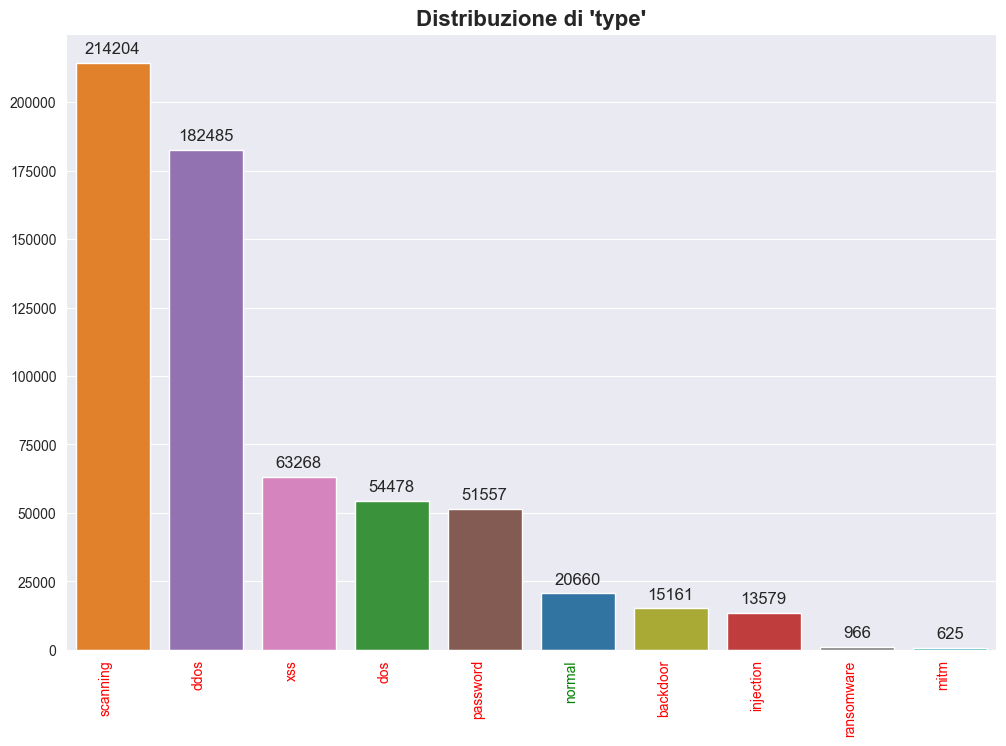

In [8]:
# Crea un grafico a barre per la distribuzione della variabile di target 'type'
plt.figure(figsize=(12, 8))
ax = sns.countplot(data=df1, x='type', hue='type', palette='tab10', order=df1['type'].value_counts().index)

# Aggiungi i conteggi sopra ogni bin
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10), textcoords='offset points', fontsize=12)

# Personalizza il grafico
plt.title('Distribuzione di \'type\'', fontweight='bold', fontsize=16)
plt.xlabel('')
plt.ylabel('')

# Cambia il colore delle etichette dell'asse x
for label in ax.get_xticklabels():
    if label.get_text() == 'normal':
        label.set_color('green')
    else:
        label.set_color('red')

plt.xticks(rotation=90, ha='right')
plt.show()

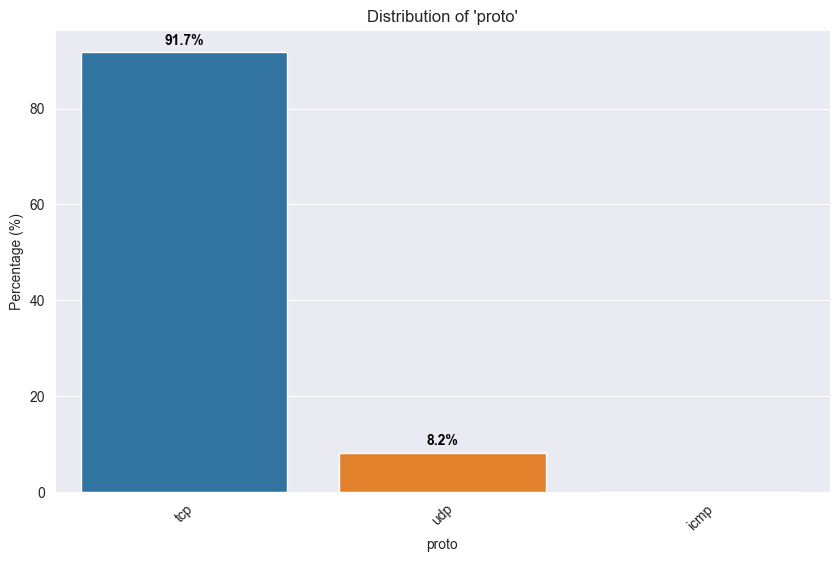

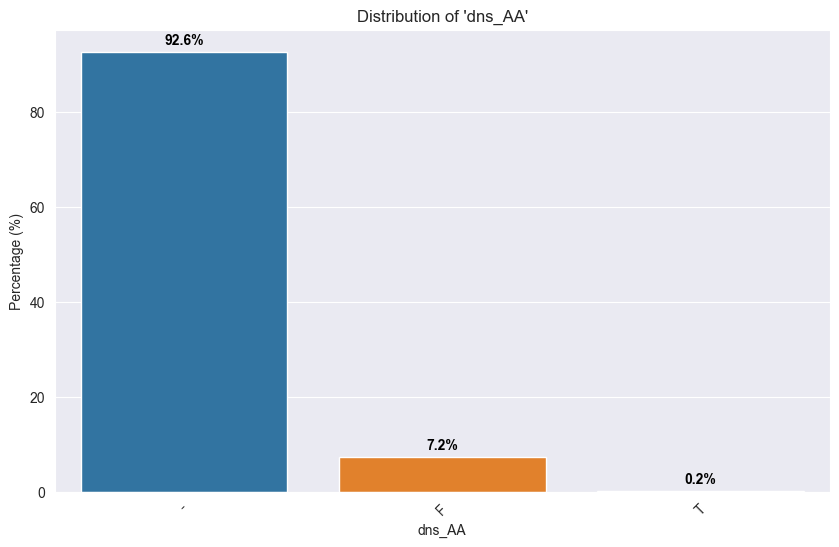

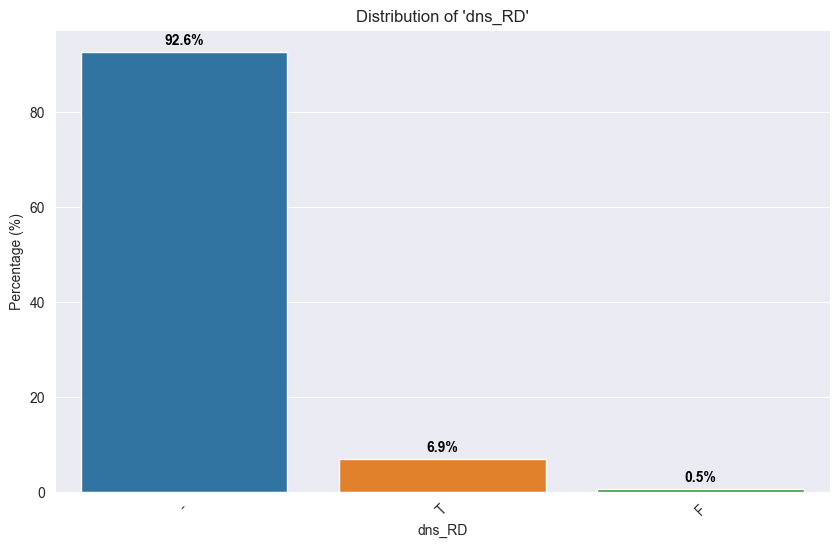

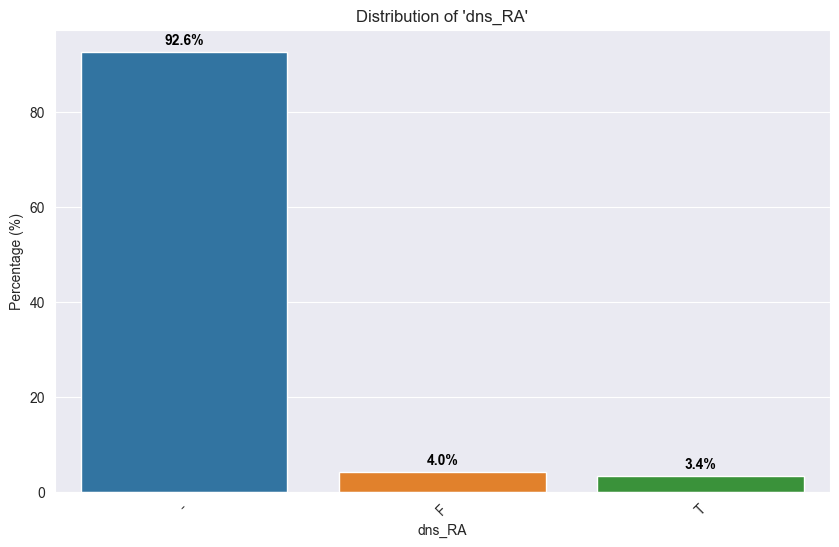

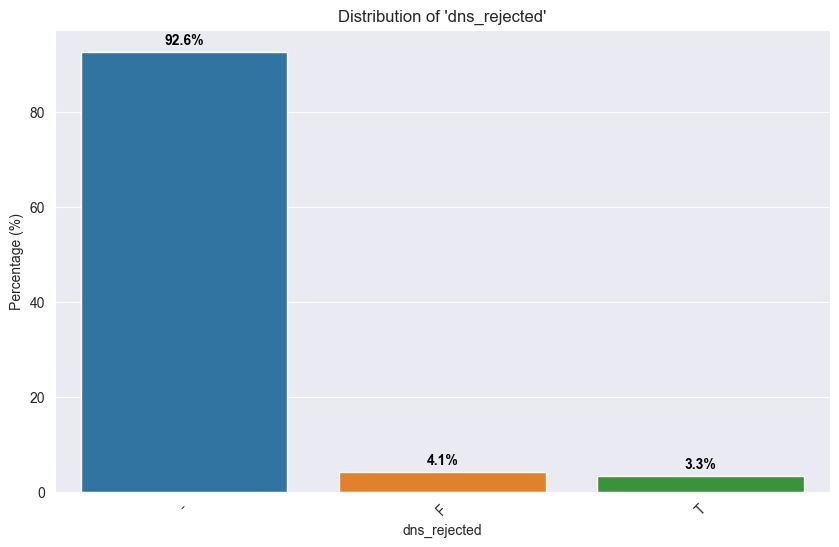

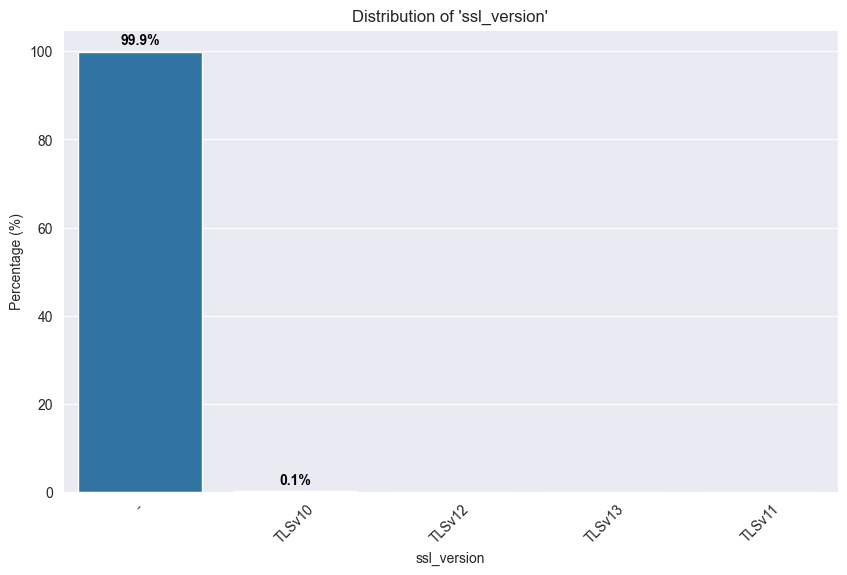

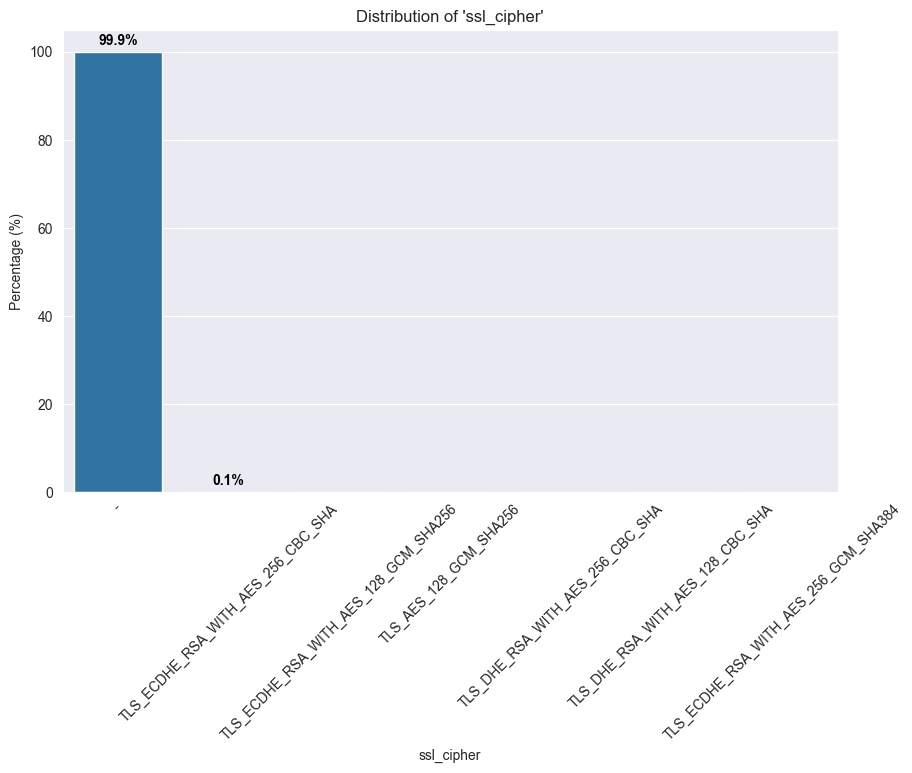

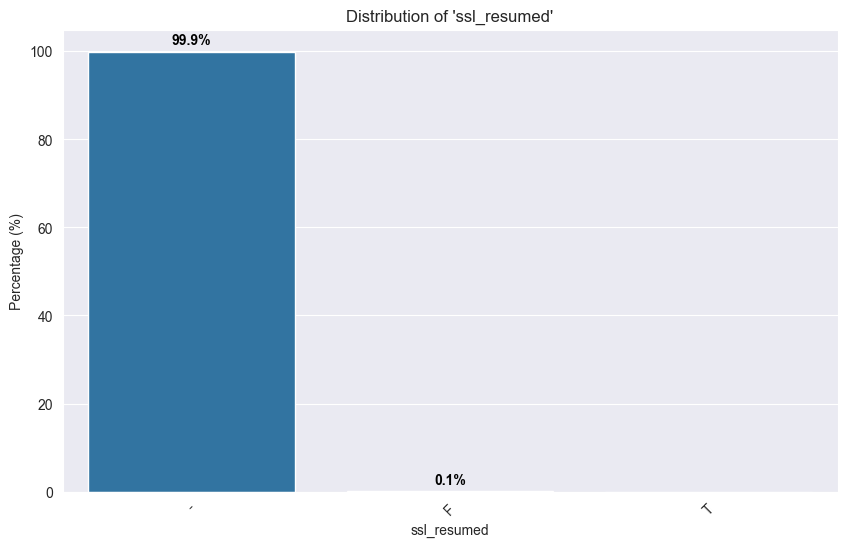

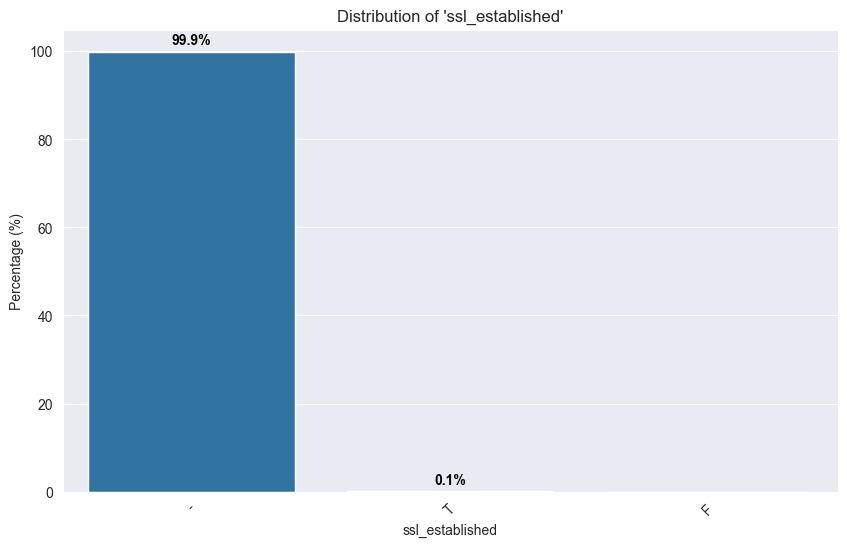

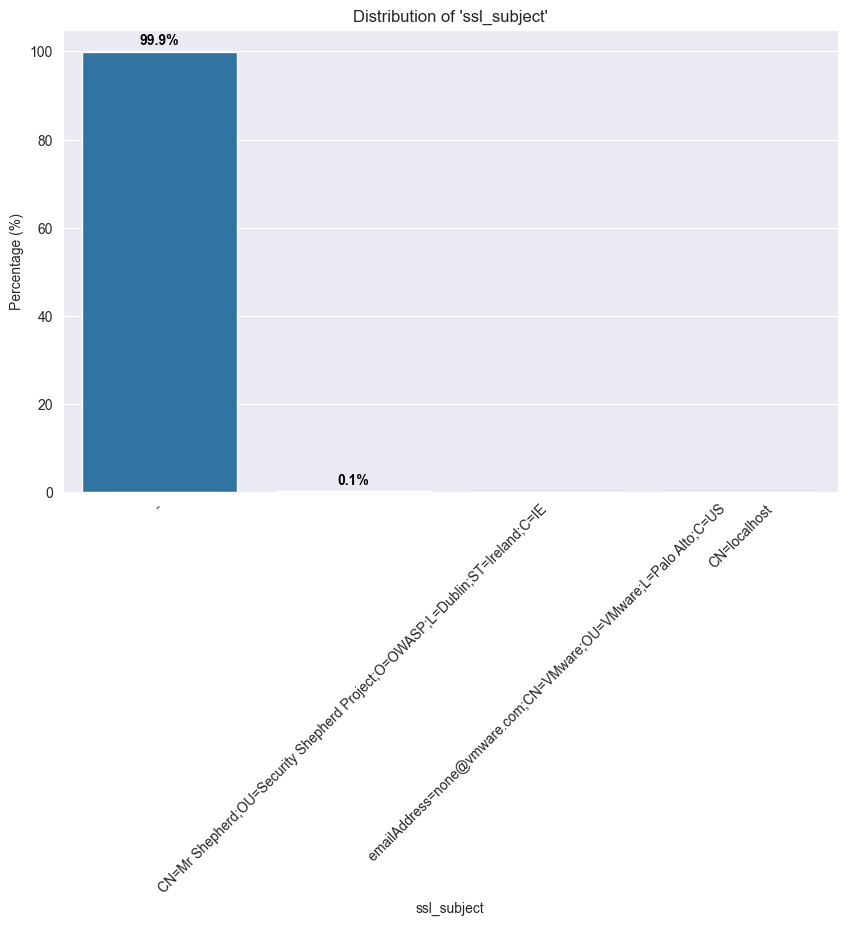

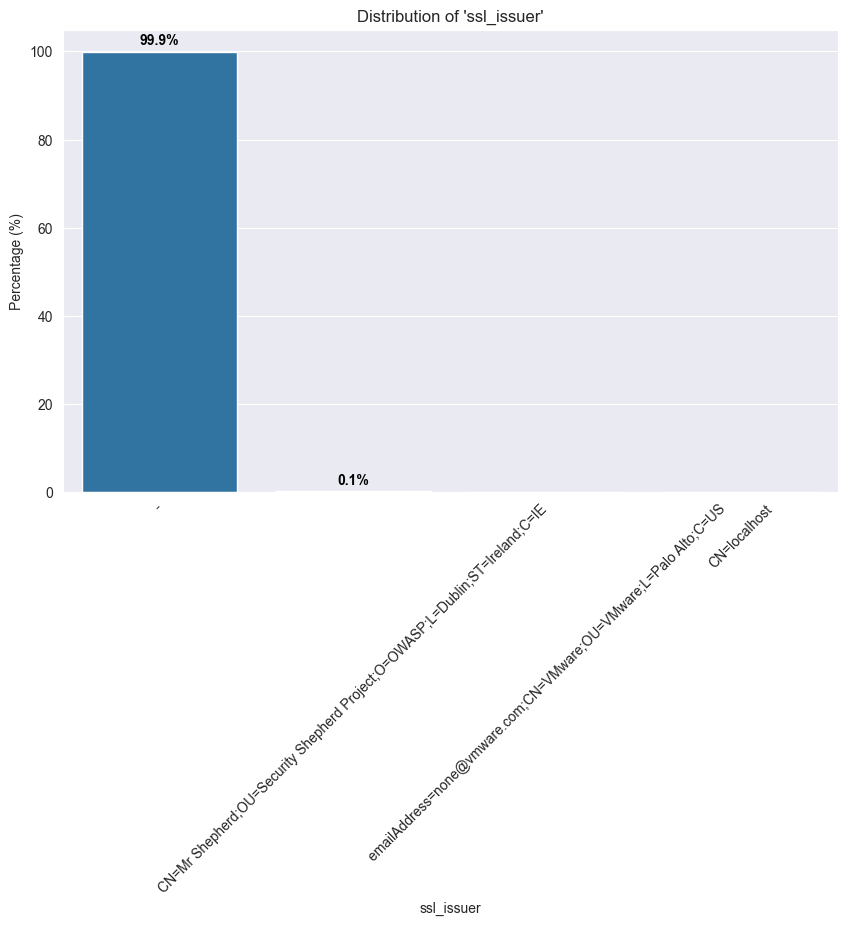

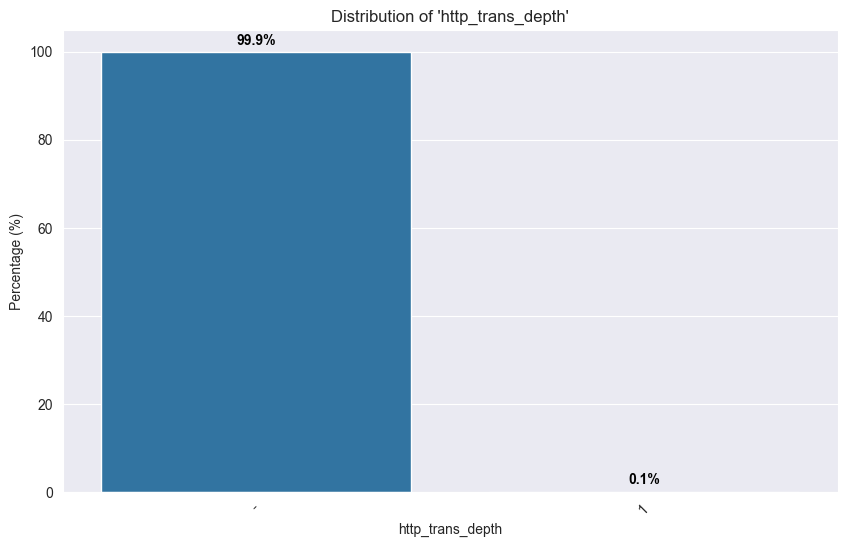

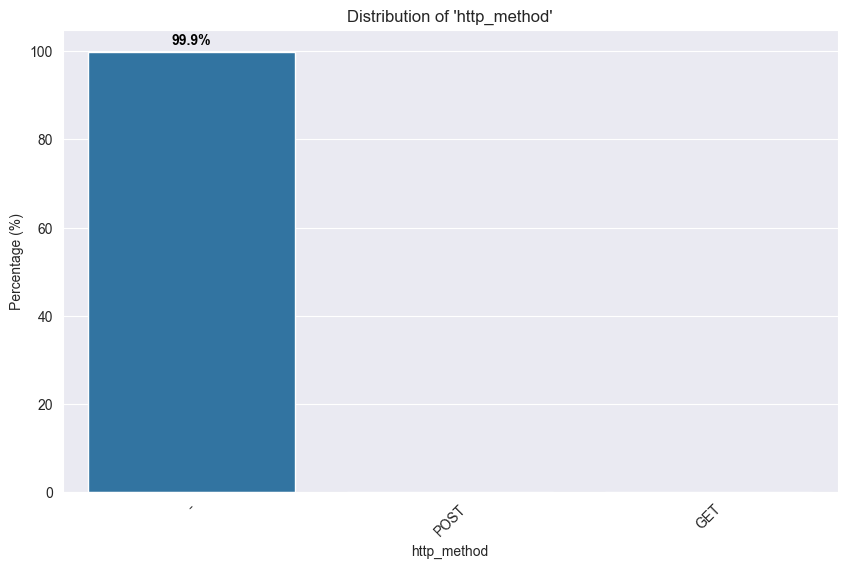

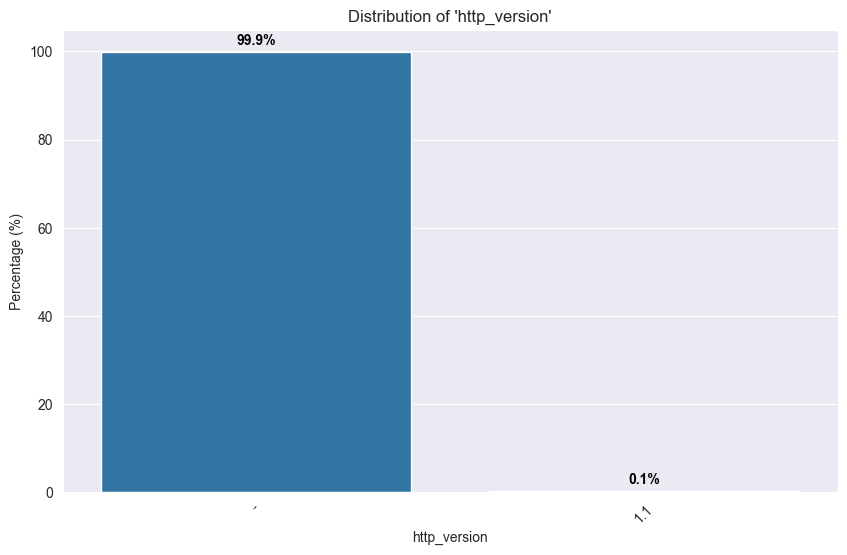

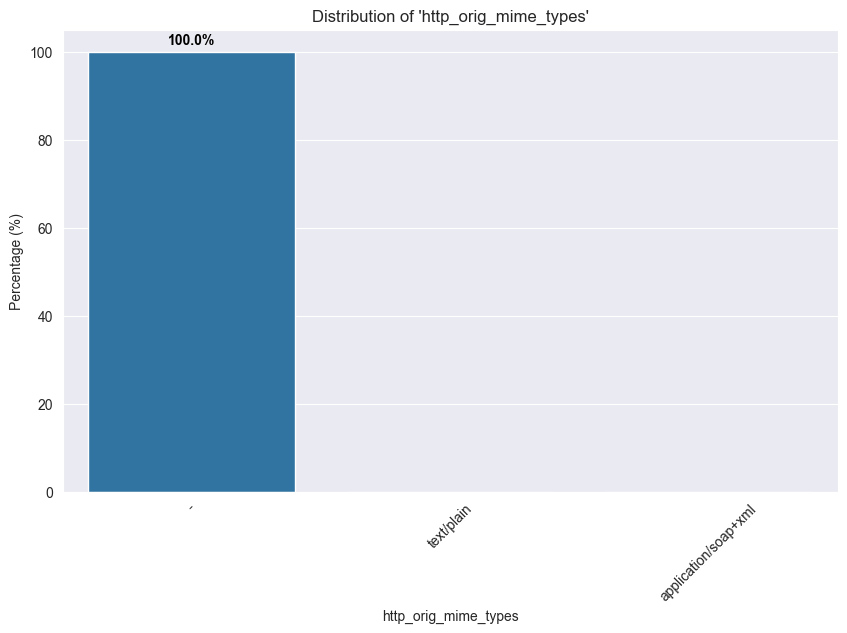

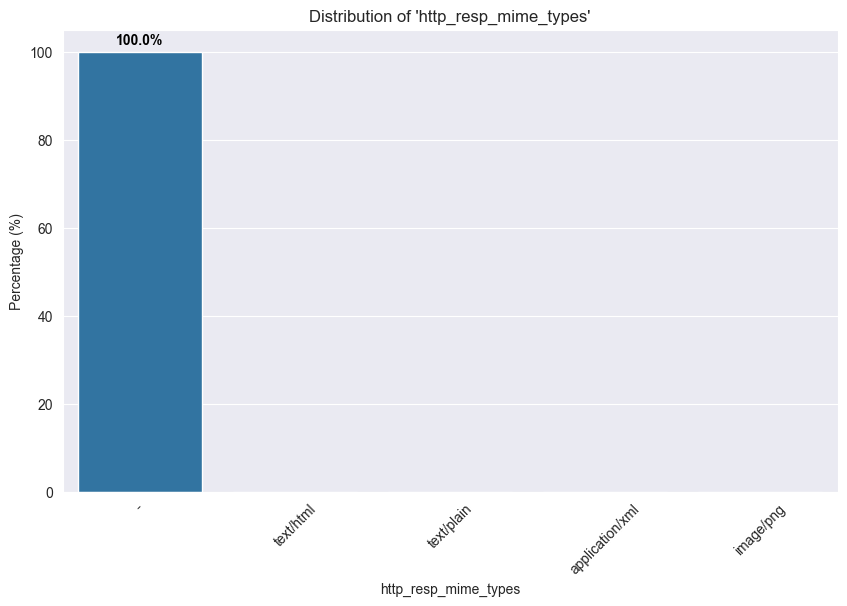

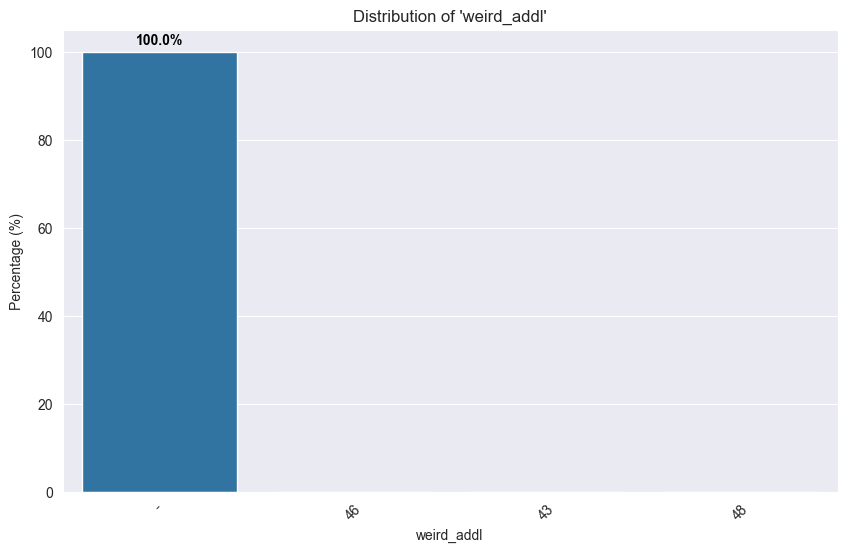

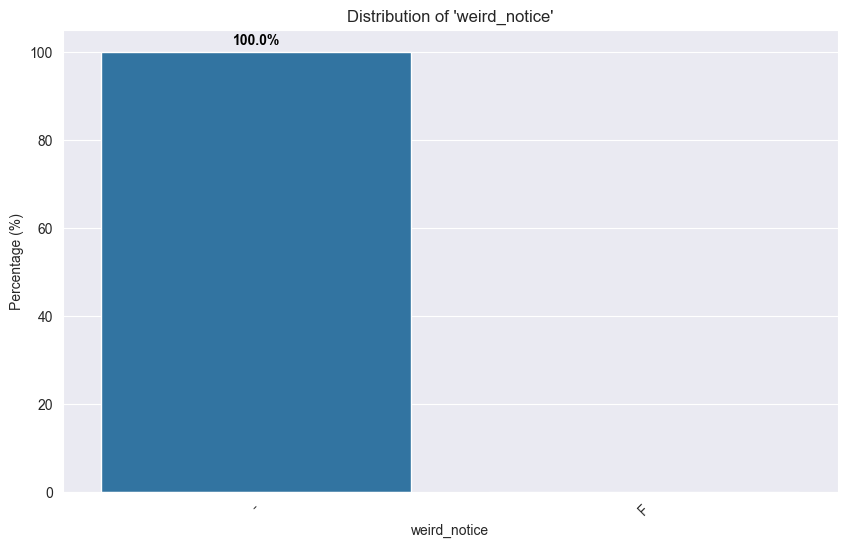

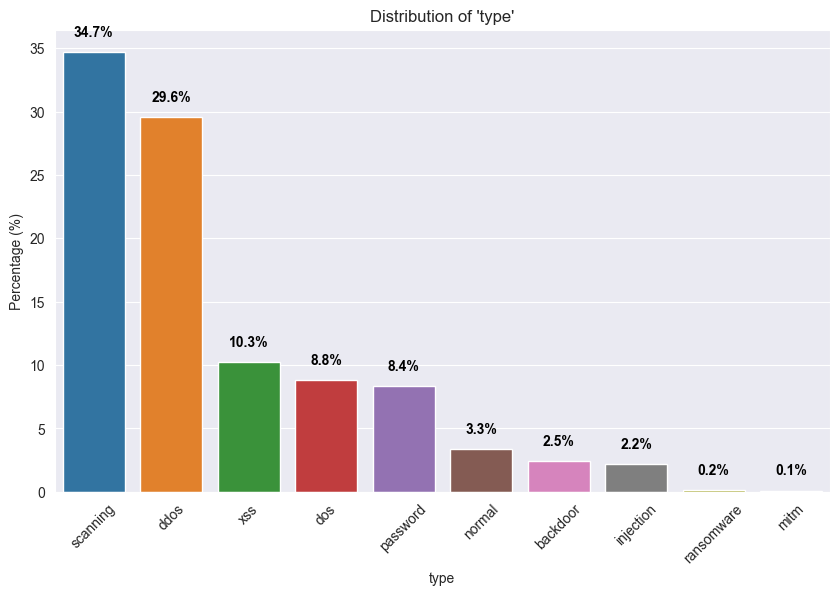

In [8]:
# get categorical columns
categorical_columns = df1.select_dtypes(include=["object"]).columns.tolist()


def plot_categorical_distribution(df, categorical_columns, max_unique_values=10):
    for col in categorical_columns:
        if df[col].nunique() <= max_unique_values:
            value_counts = df[col].value_counts(normalize=True) * 100  # Calculate percentages

            plt.figure(figsize=(10, 6))
            ax = sns.barplot(
                x=value_counts.index,
                y=value_counts.values,
                hue=value_counts.index,
                palette='tab10'
            )

            # Aggiungere le percentuali sopra ogni barra
            for p in ax.patches:
                height = p.get_height()
                if height >= 0.1:  # Evita di scrivere 0%
                    ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.1f}%',
                            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel("Percentage (%)")
            plt.xticks(rotation=45)
            plt.show()


# Esegui la funzione
plot_categorical_distribution(df1, categorical_columns)


# Variabili numeriche

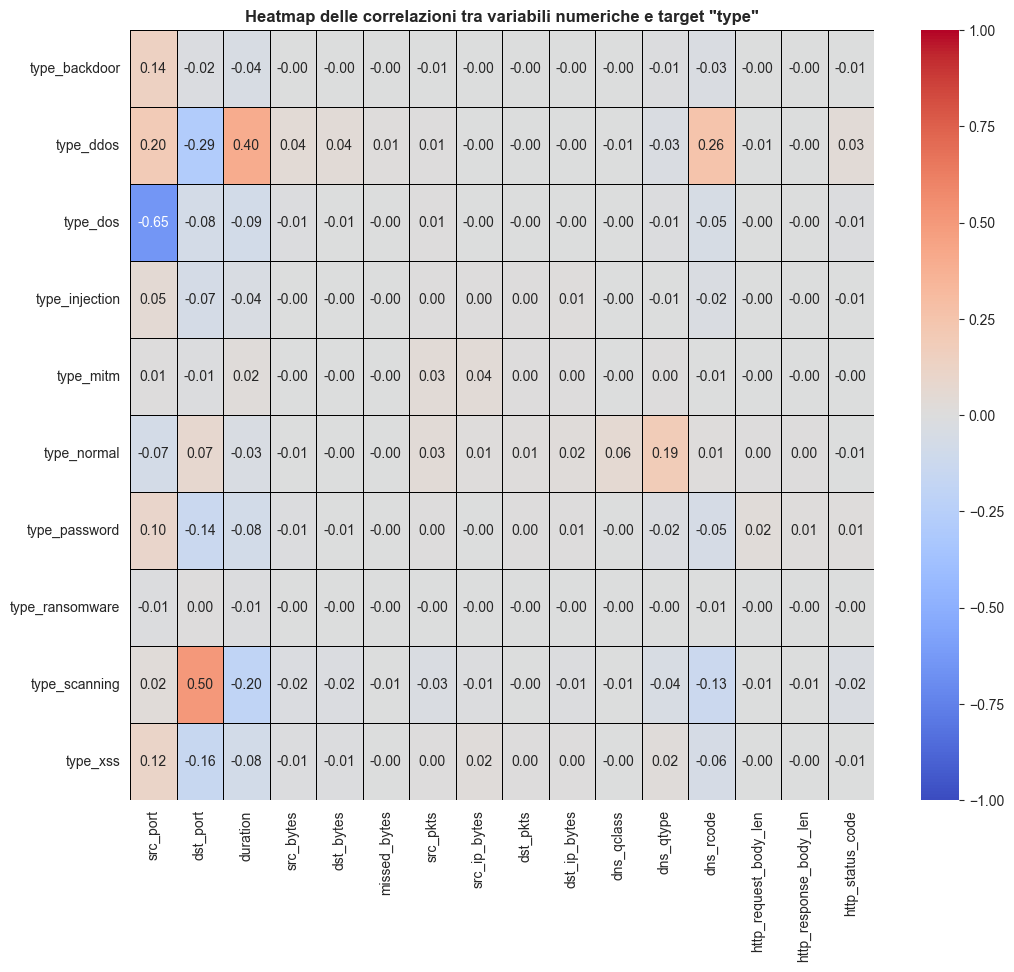

In [27]:
# Seleziona le variabili numeriche ed escludi le colonne 'ts' e 'label'
numeric_columns = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_columns = [col for col in numeric_columns if col not in ['ts', 'label']]

# One-hot encode the 'type' variable
encoded_type = pd.get_dummies(df1['type'], prefix='type')

# Concatenate the encoded 'type' variable with the numeric columns
df_encoded = pd.concat([X[numeric_columns], encoded_type], axis=1)

# Calcola la matrice di correlazione
correlation_matrix = df_encoded.corr().iloc[16:, :16]

# Crea una heatmap delle correlazioni senza annotazioni e con bordo nero tra le celle
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", vmin=-1, vmax=1, linecolor='black', linewidths=0.5)
plt.title('Heatmap delle correlazioni tra variabili numeriche e target "type"', fontweight='bold')
plt.show()

## Distribuzioni variabili numeriche rispetto ai valori di target

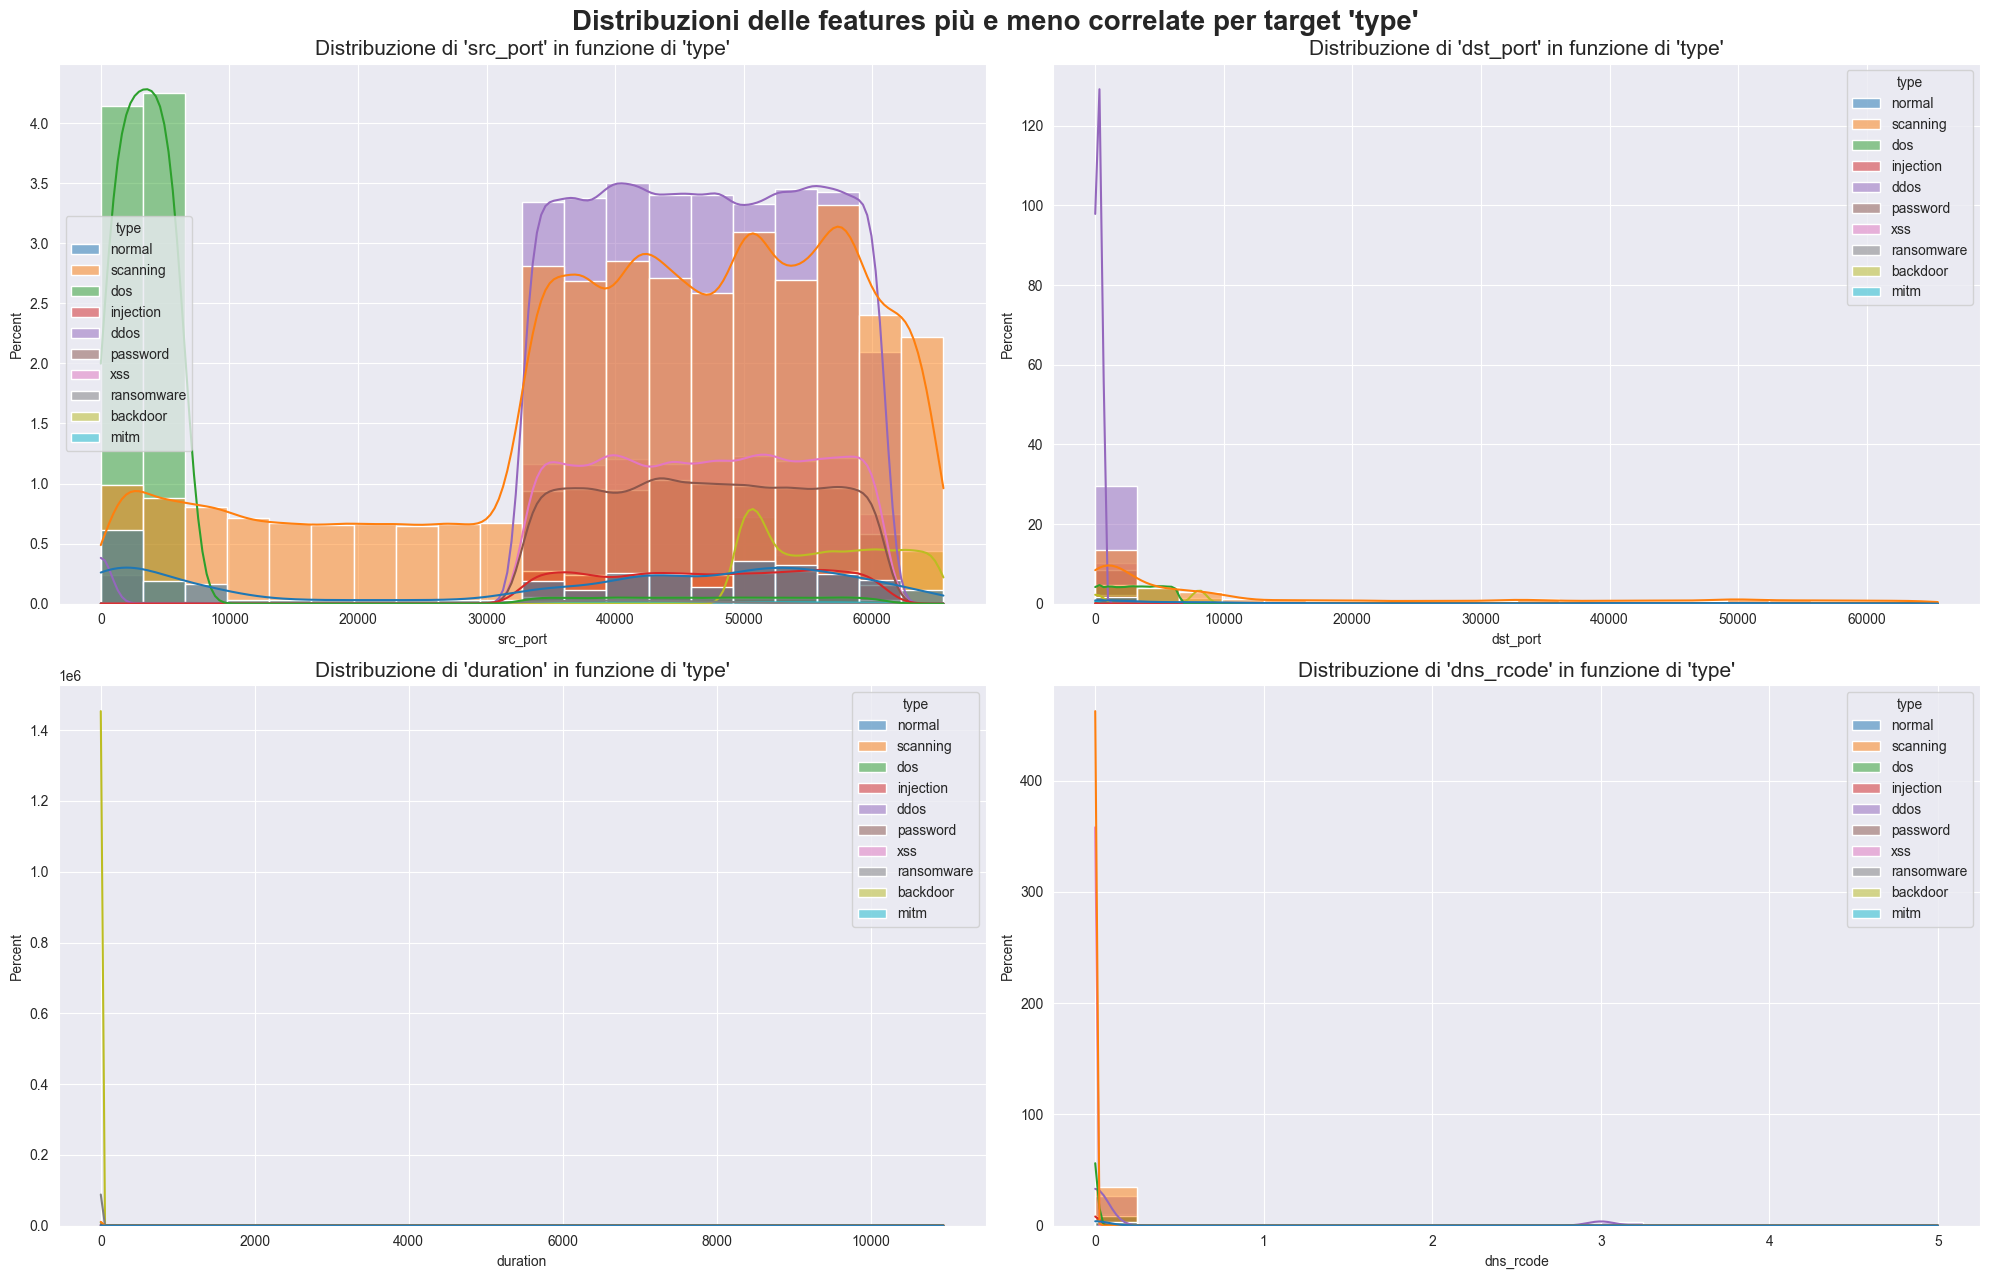

In [40]:
# list columns in correlation_matrix with a correlation > 0.25 with any type
feature_corr = [col for col in correlation_matrix.columns if any(abs(correlation_matrix[col]) >= 0.25)]

# Lista delle feature continue e della variabile target
# feature_corr = ['dst_port', 'src_port', 'duration', 'dns_rcode']
target = 'type'

# Numero di colonne e righe per i sottografi
n_cols = 2
n_rows = int(np.ceil(len(feature_corr) / n_cols))

# Creazione del grafico
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 13))

# Se c'è un solo grafico, assicuriamoci che axes sia una lista
if n_rows * n_cols == 1:
    axes = [axes]

# Flatten degli assi nel caso di più righe/colonne
axes = np.ravel(axes)

bins = 20  # Numero di bins per gli istogrammi
custom_palette = sns.color_palette("tab10")  # Scegli una palette diversa

for i, column in enumerate(feature_corr):
    ax = sns.histplot(
        x=column,
        data=df1,  # Sostituisci 'df' con il tuo DataFrame
        hue=target,
        ax=axes[i],
        bins=bins,
        stat="percent",
        kde=True,
        legend=True,
        palette=custom_palette  # Applica la palette personalizzata
    )
    axes[i].set_title(f'Distribuzione di \'{column}\' in funzione di \'type\'', size=15)

# Rimuove assi vuoti (se presenti)
for j in range(len(feature_corr), len(axes)):
    fig.delaxes(axes[j])

# Titolo generale del grafico
fig.suptitle('Distribuzioni delle features più e meno correlate per target \'type\'', fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()

## Boxplots variabili numeriche rispetto ai valori di target

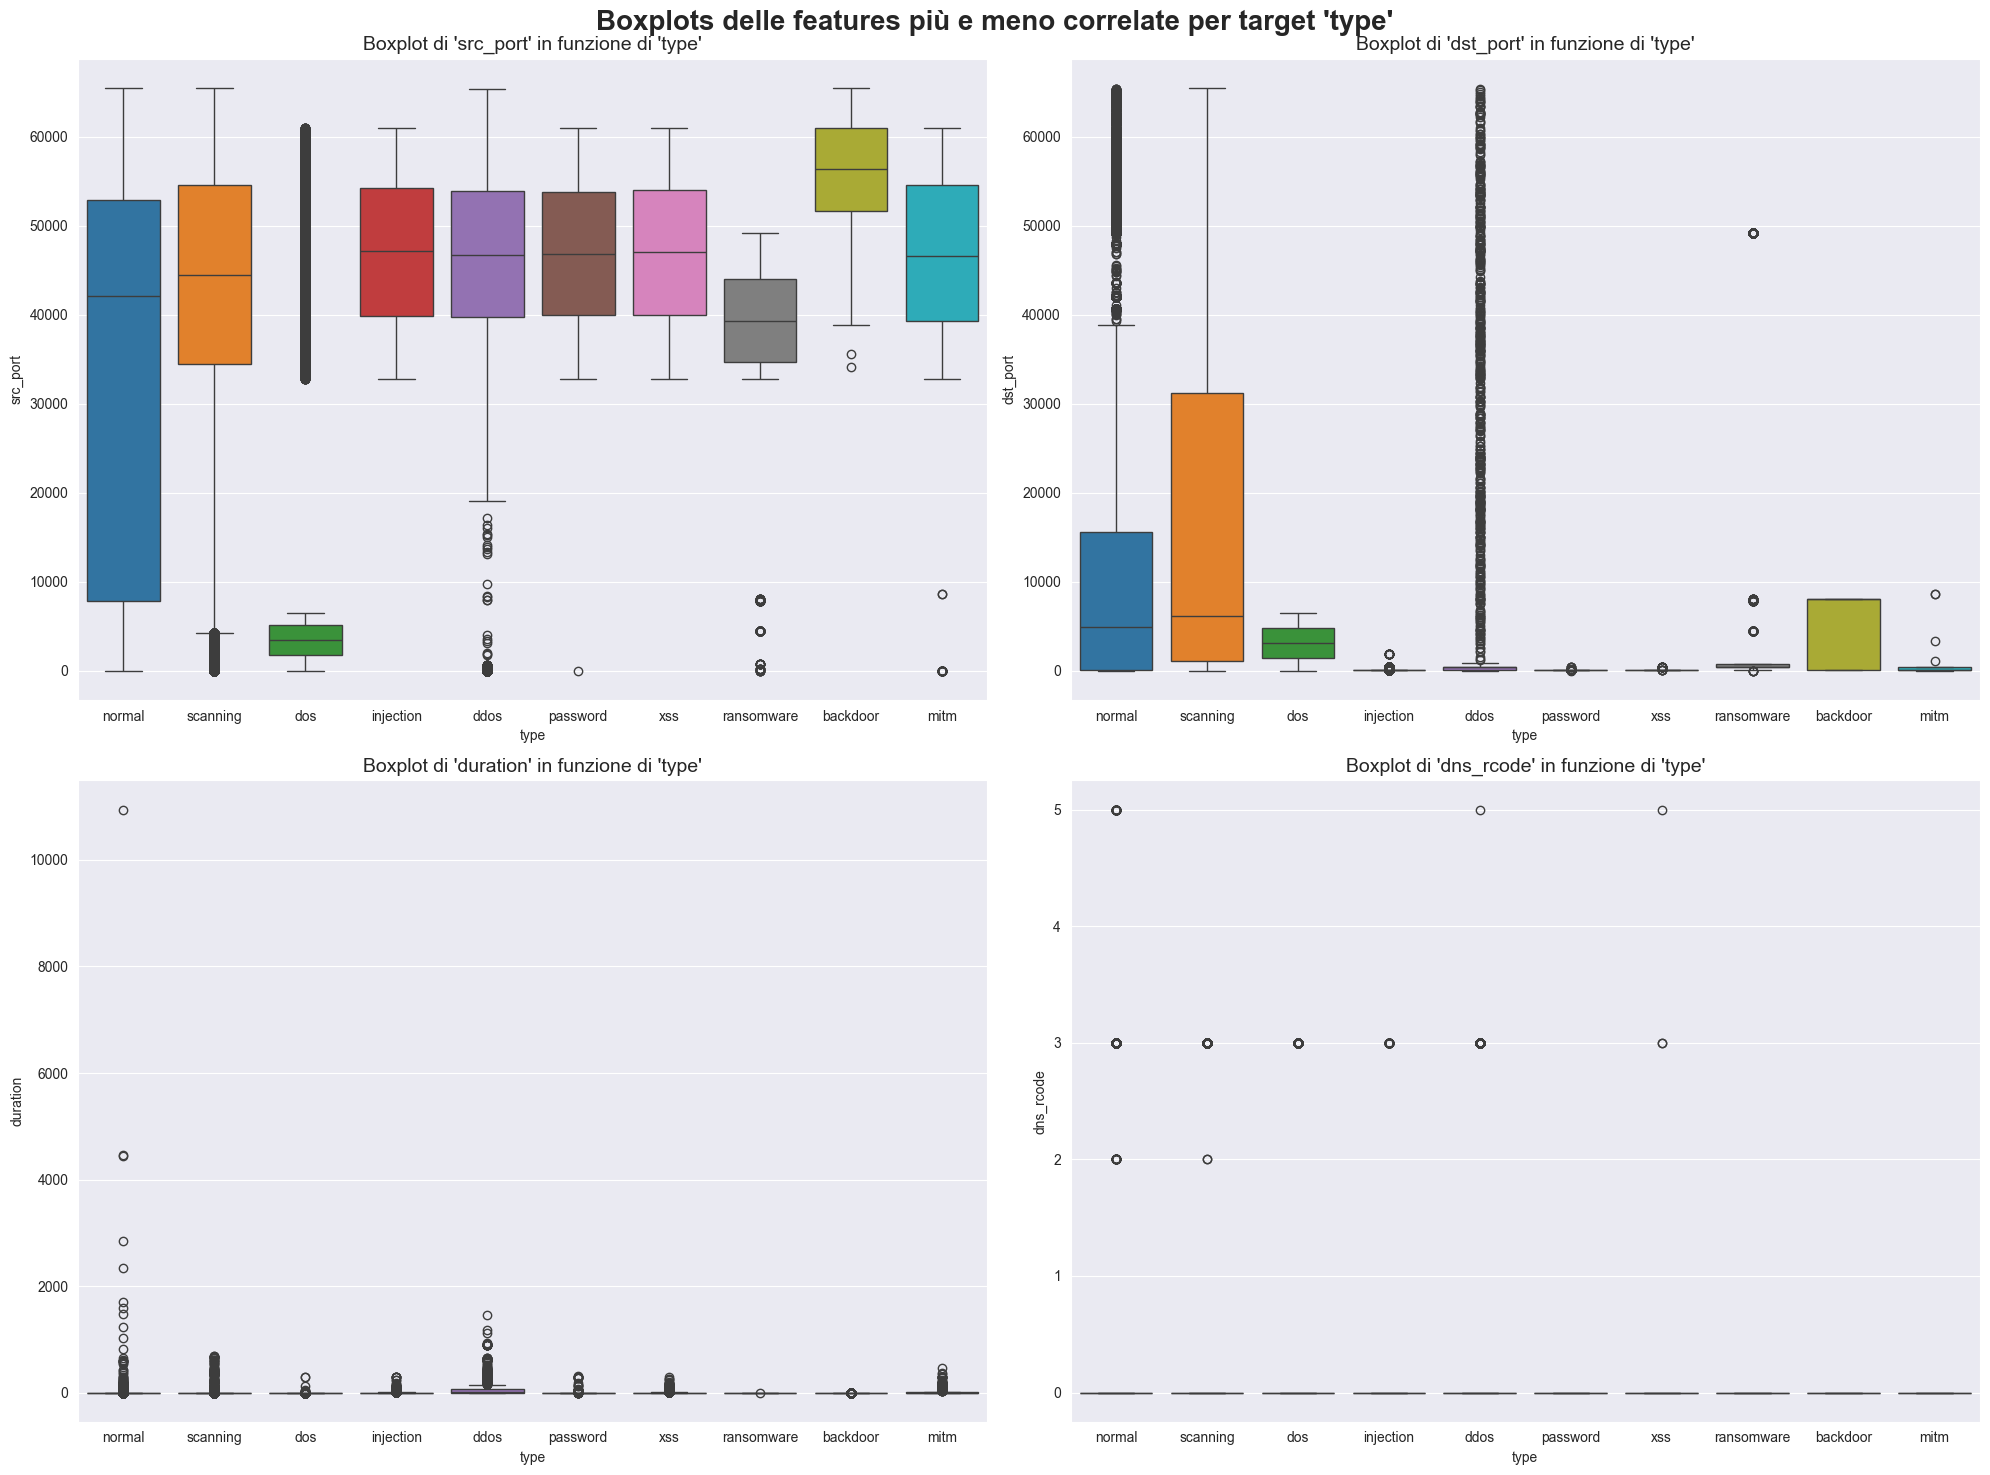

In [41]:
n_cols = 2
n_rows = int(np.ceil(len(feature_corr) / n_cols))

# Creazione del grafico
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 15))

# Flatten degli assi nel caso di più righe/colonne
axes = np.ravel(axes)

for i, column in enumerate(feature_corr):
    sns.boxplot(
        x=target,
        y=column,
        data=df1,  # Sostituisci 'df' con il tuo DataFrame
        ax=axes[i],
        hue=target,
        palette="tab10"  # Palette di colori personalizzata
    )
    axes[i].set_title(f'Boxplot di \'{column}\' in funzione di \'{target}\'', size=14)
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(column)

# Rimuove assi vuoti (se presenti)
for j in range(len(feature_corr), len(axes)):
    fig.delaxes(axes[j])

# Titolo generale del grafico
fig.suptitle('Boxplots delle features più e meno correlate per target \'type\'', fontsize=20, fontweight='bold')
fig.tight_layout()
plt.show()

proto


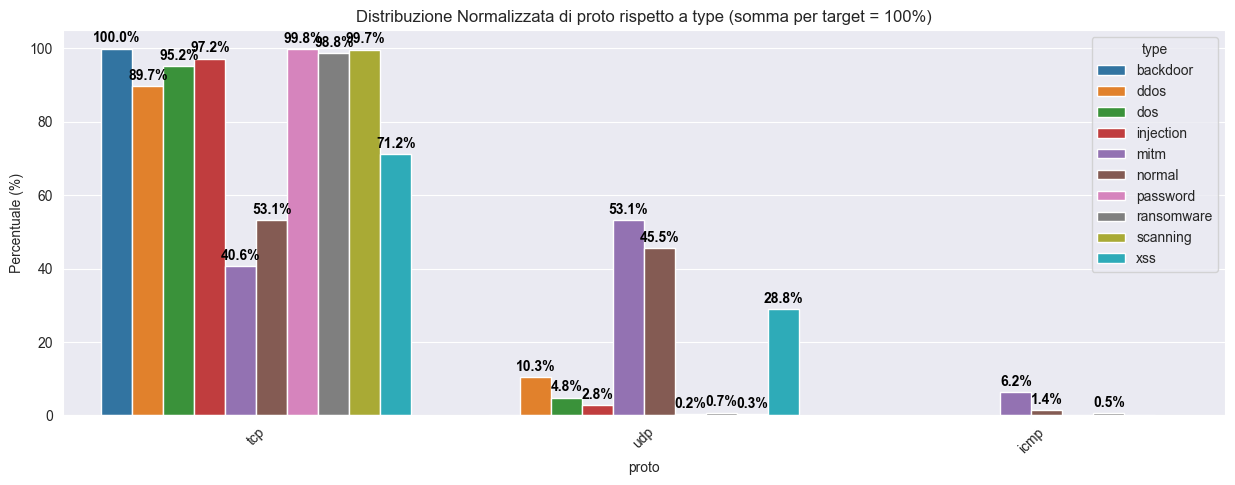

conn_state


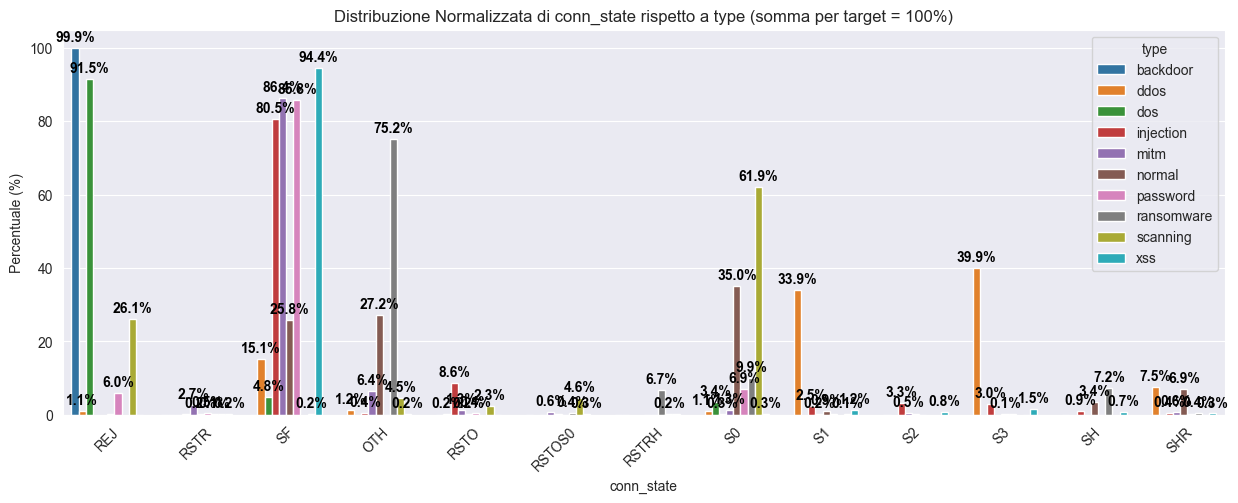

dns_AA


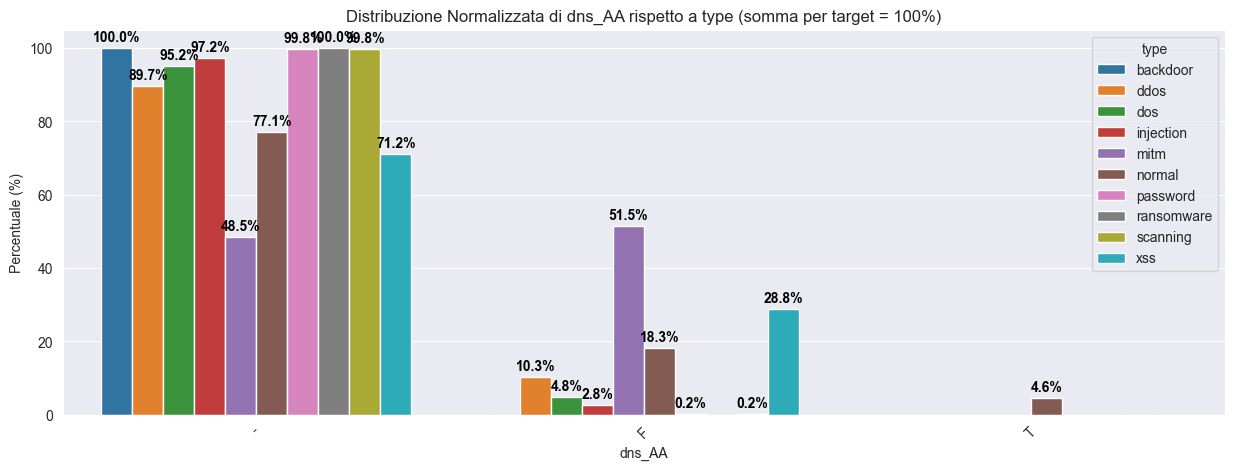

dns_RD


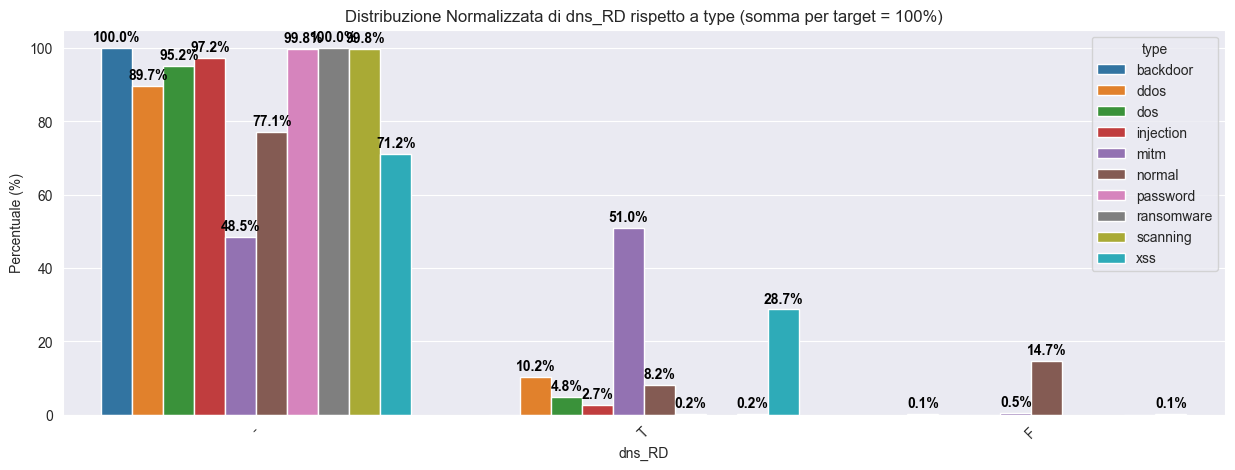

dns_RA


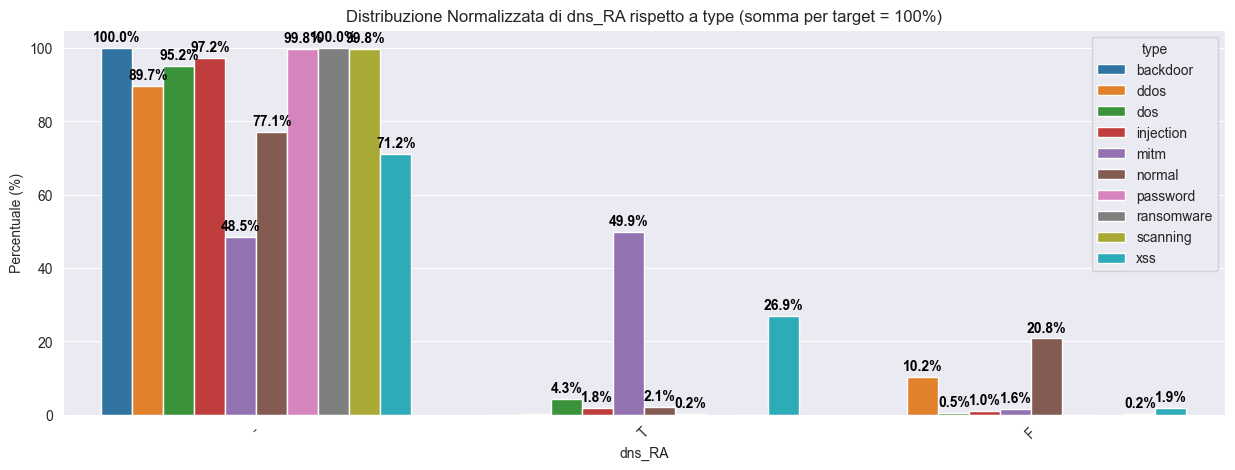

dns_rejected


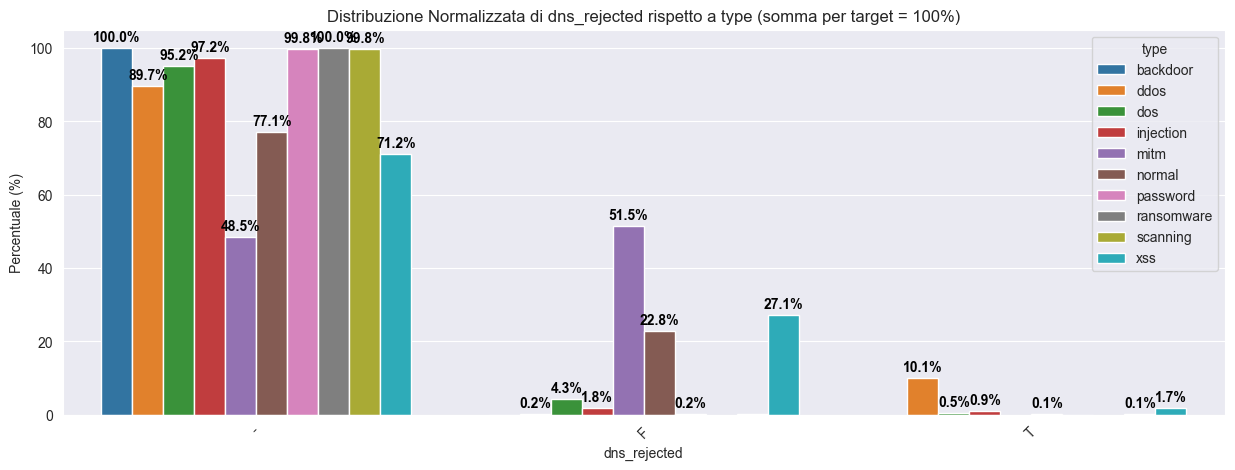

ssl_version


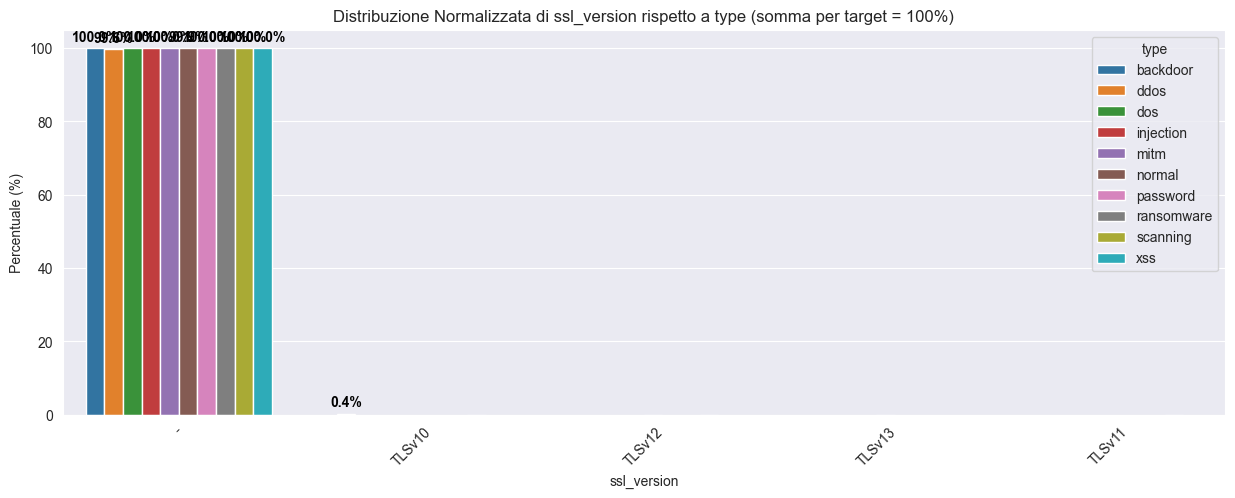

ssl_cipher


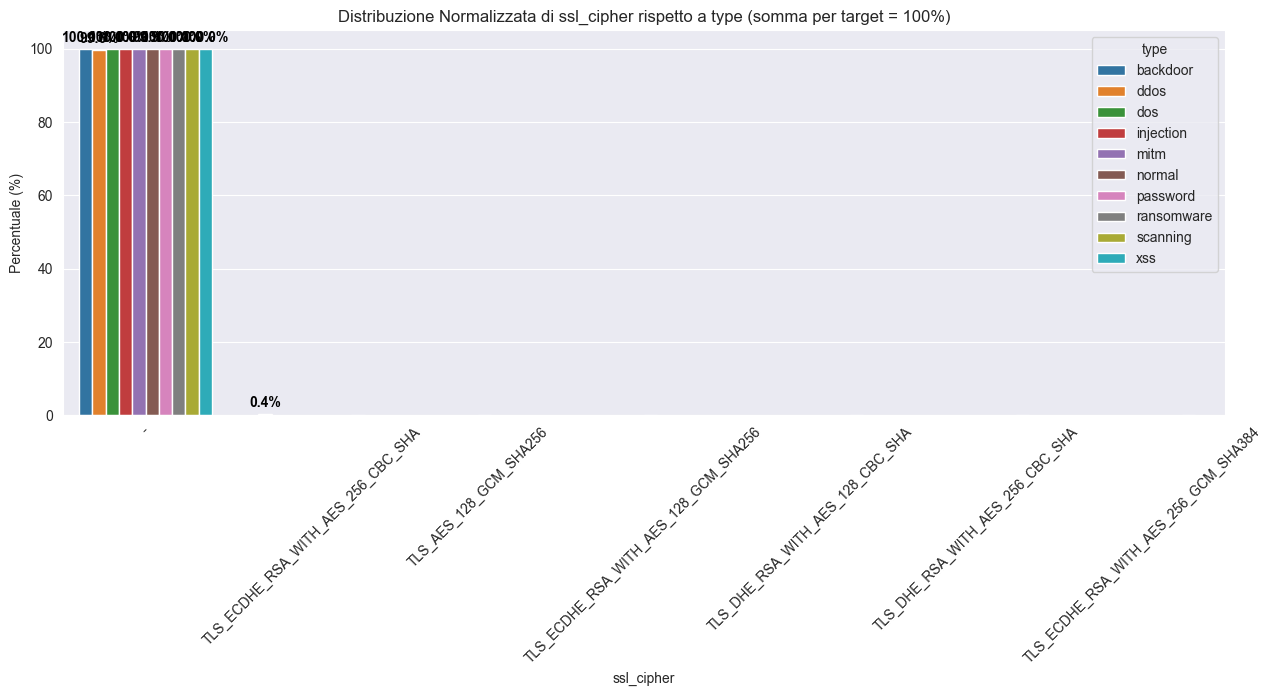

ssl_resumed


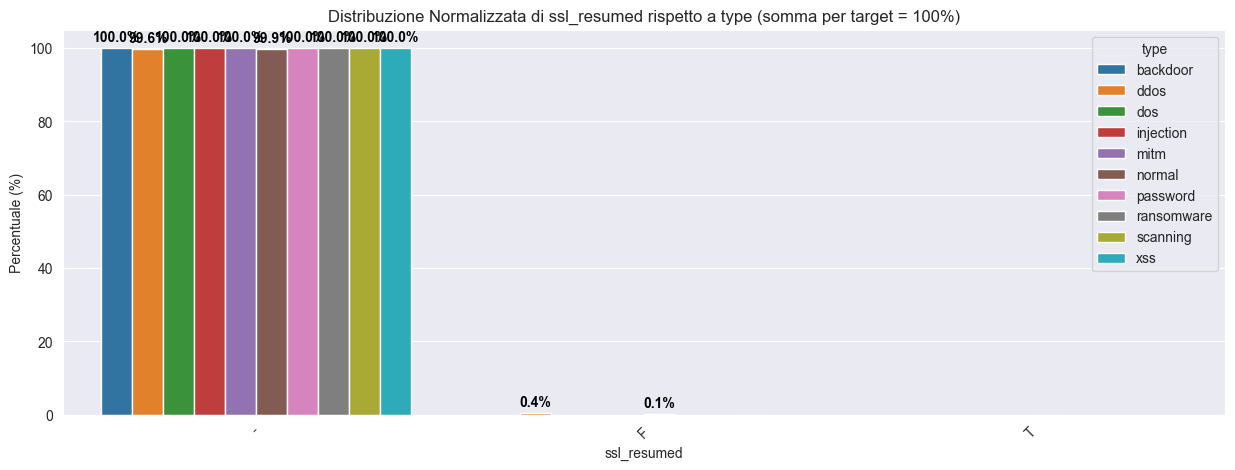

ssl_established


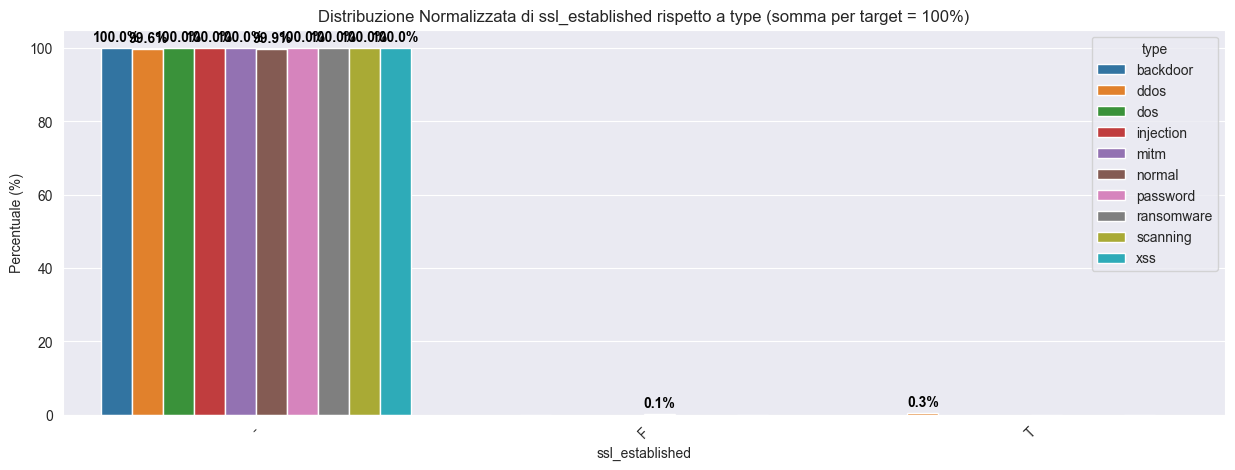

ssl_subject


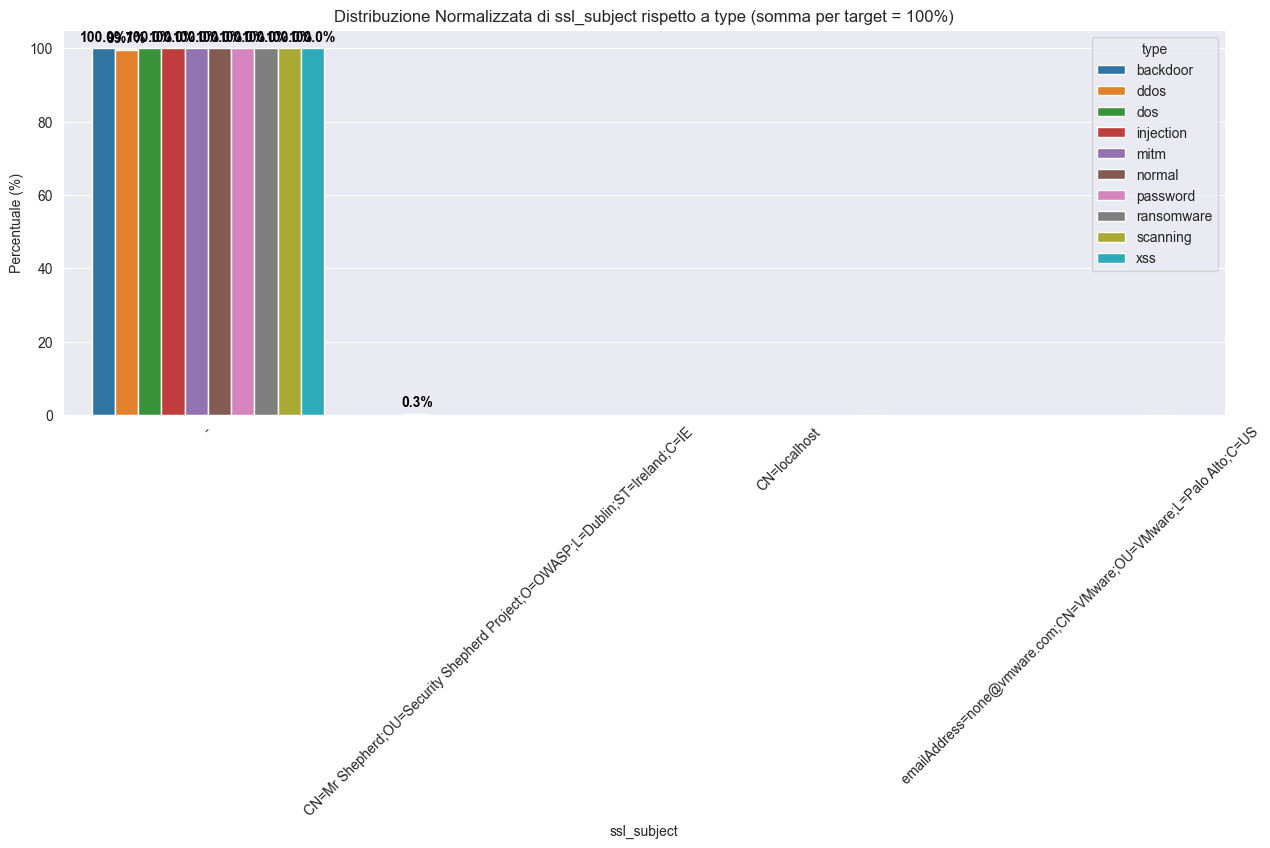

ssl_issuer


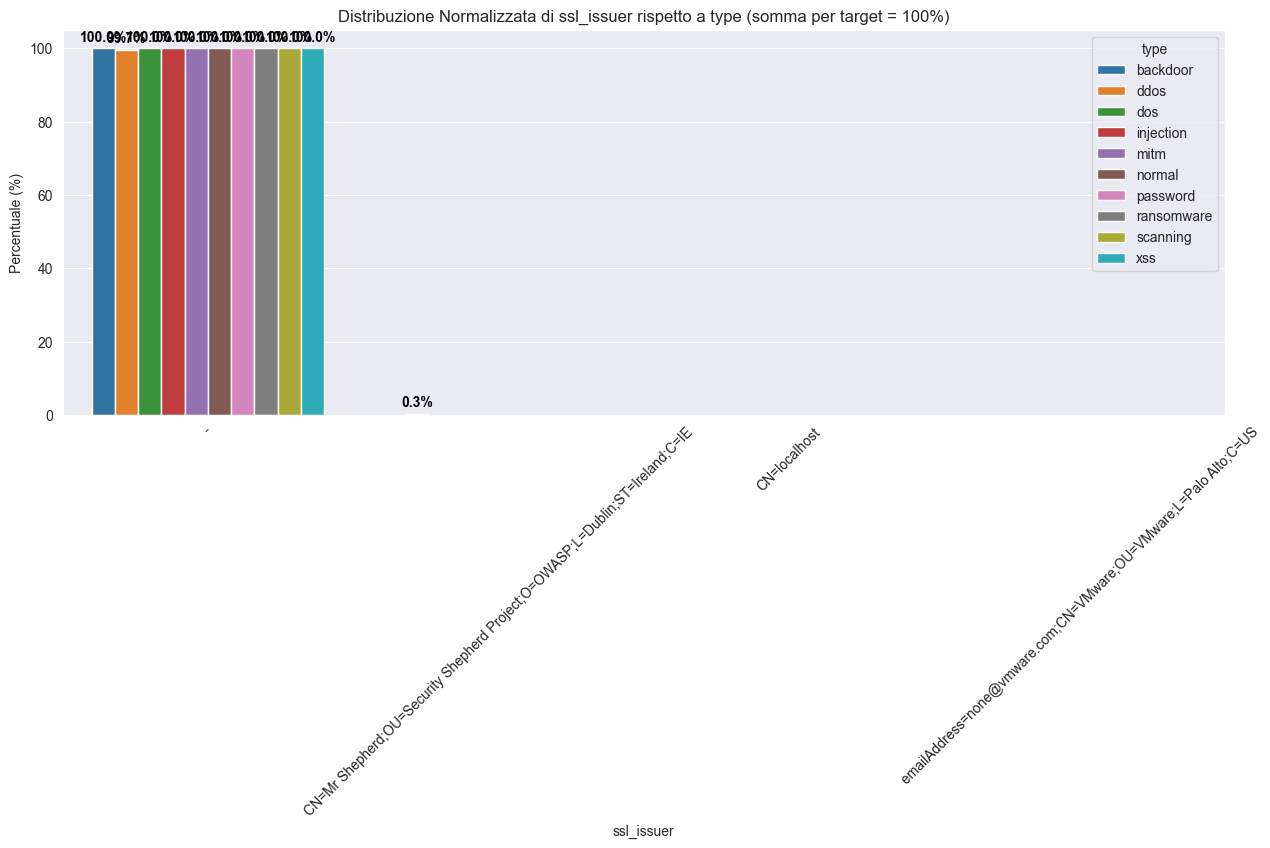

http_trans_depth


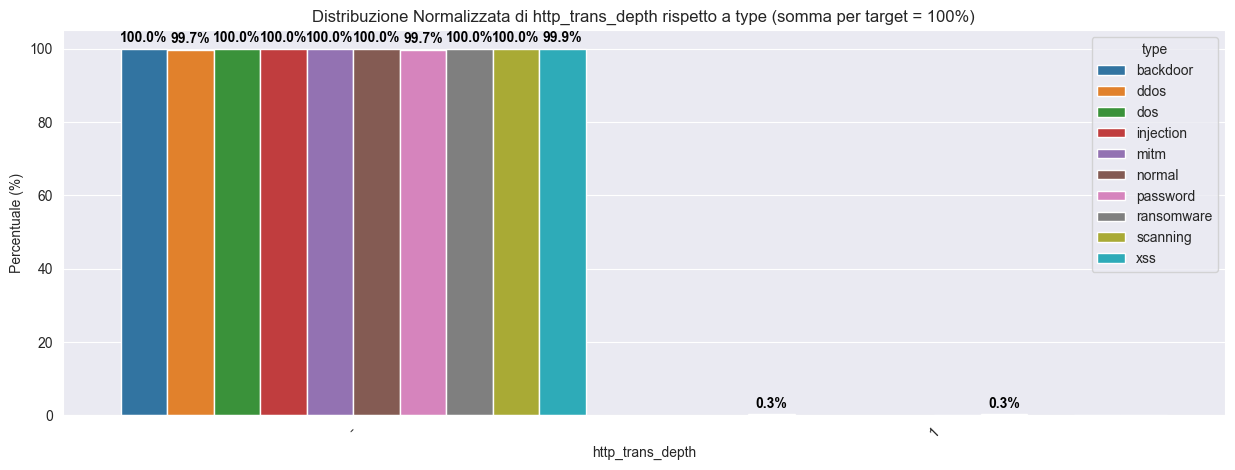

http_method


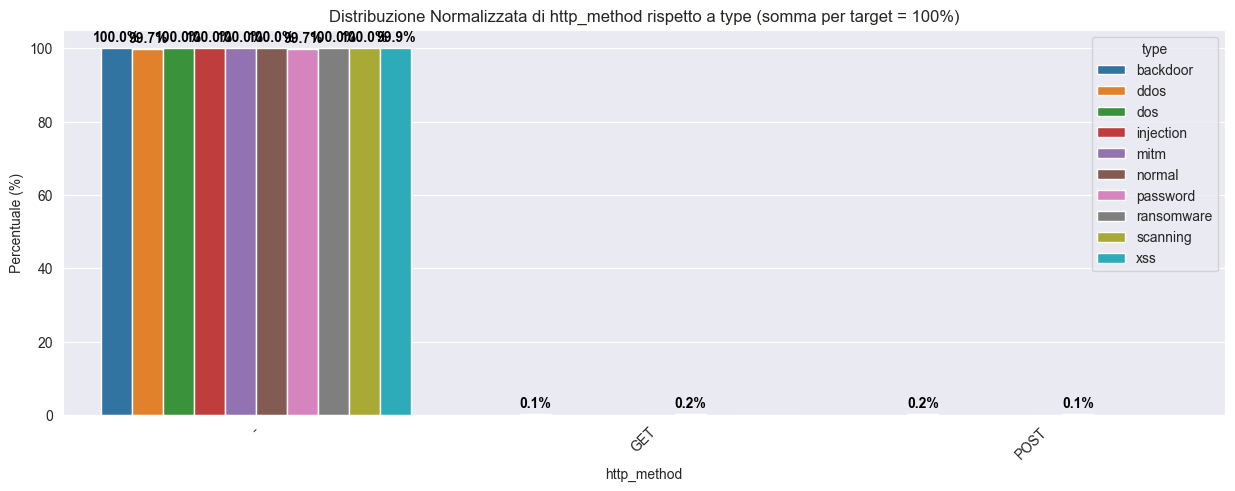

http_referrer


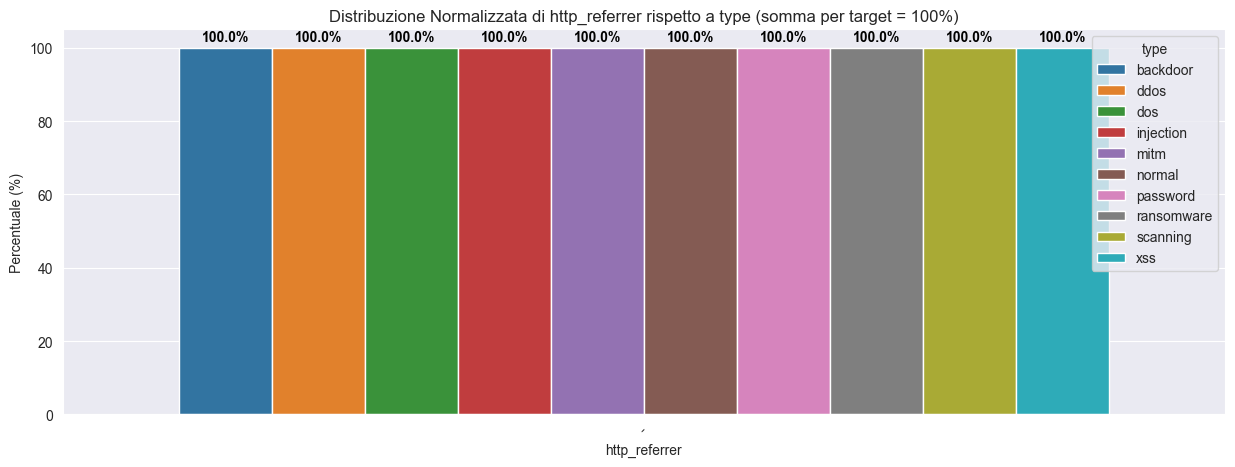

http_version


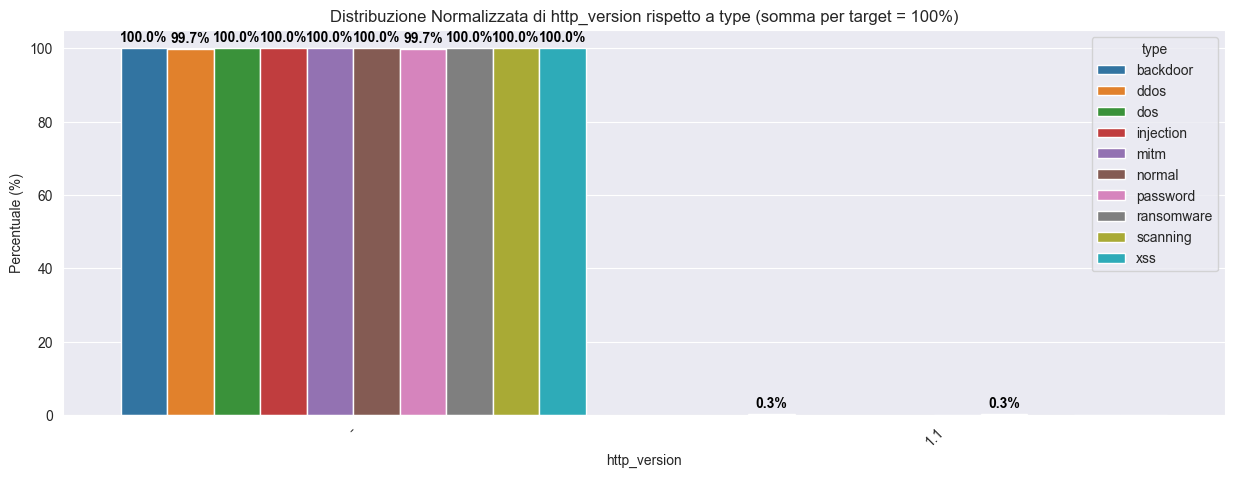

http_orig_mime_types


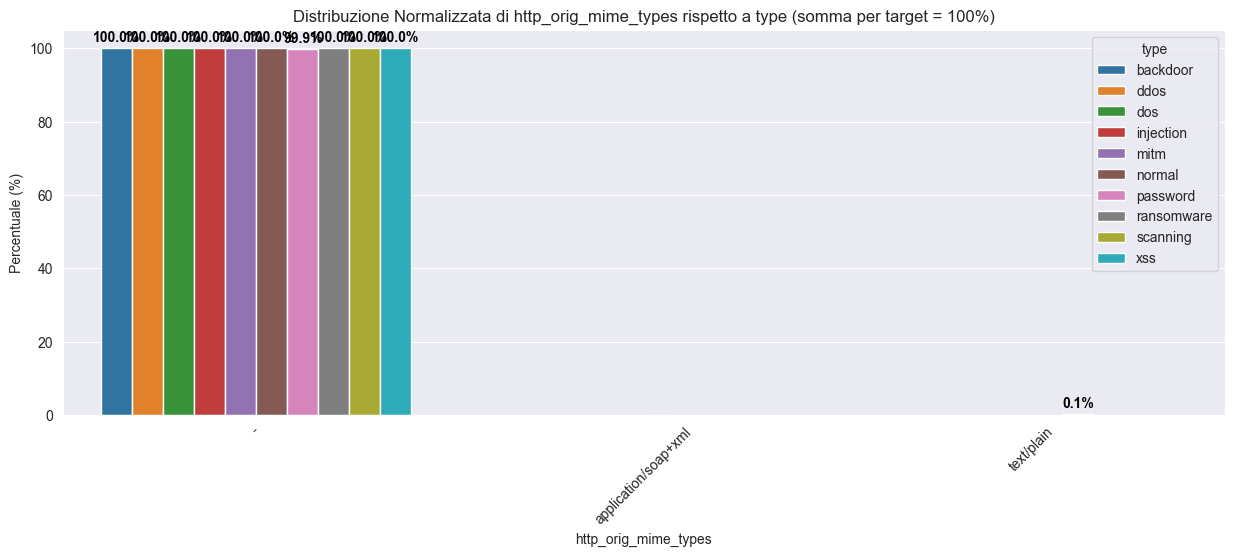

http_resp_mime_types


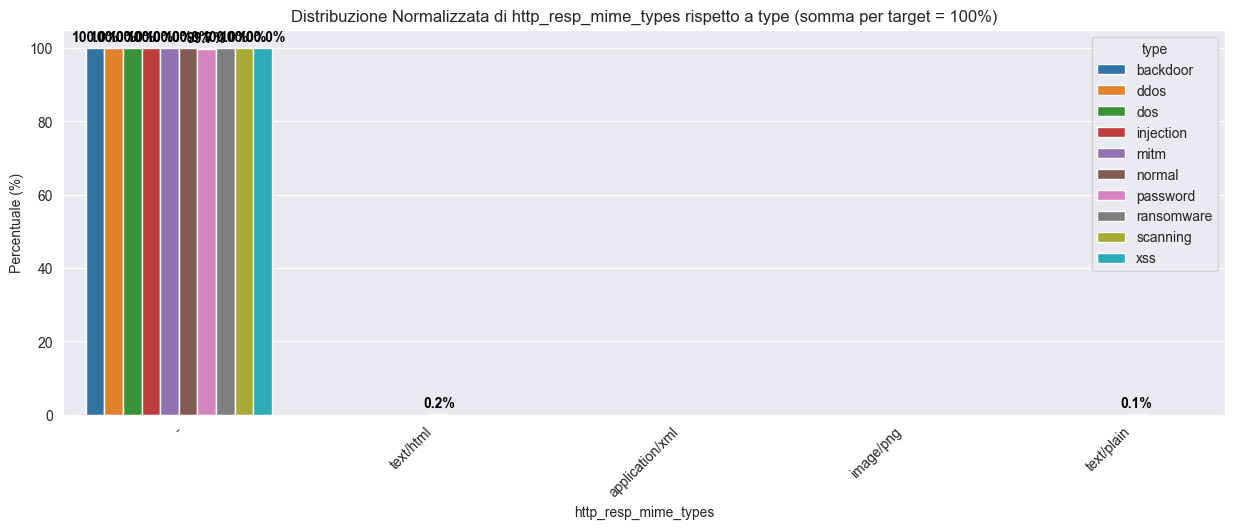

weird_name


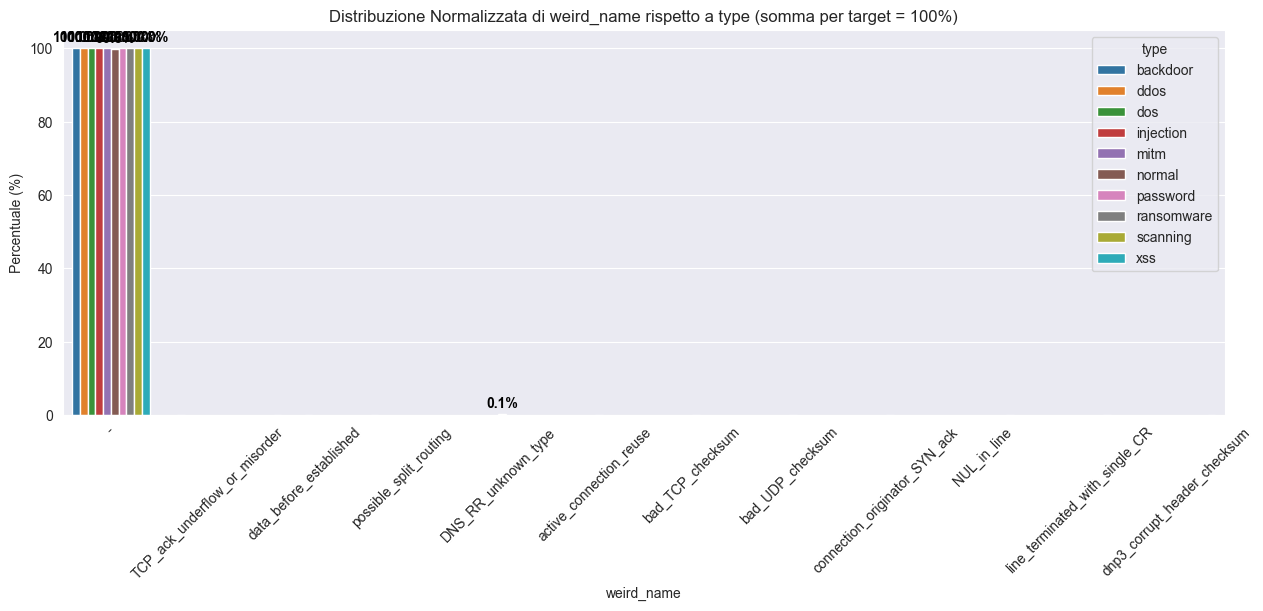

weird_addl


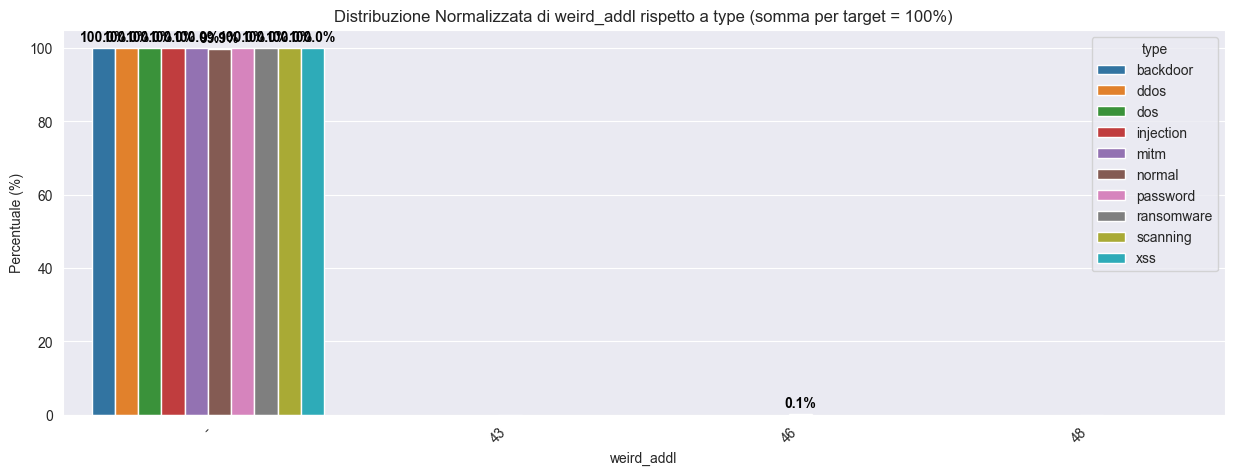

weird_notice


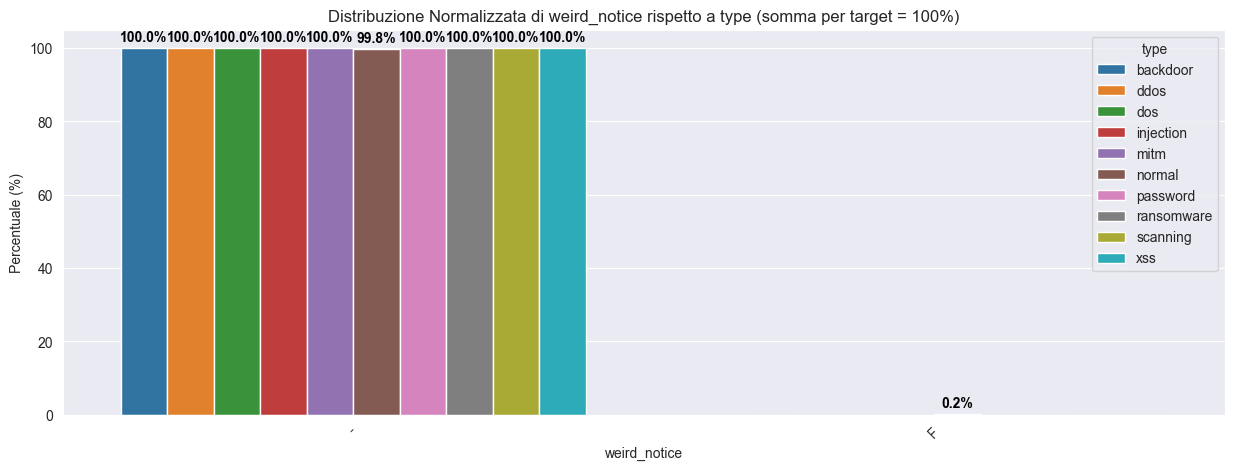

['plots/proto_normalized_by_type.png', 'plots/conn_state_normalized_by_type.png', 'plots/dns_AA_normalized_by_type.png', 'plots/dns_RD_normalized_by_type.png', 'plots/dns_RA_normalized_by_type.png', 'plots/dns_rejected_normalized_by_type.png', 'plots/ssl_version_normalized_by_type.png', 'plots/ssl_cipher_normalized_by_type.png', 'plots/ssl_resumed_normalized_by_type.png', 'plots/ssl_established_normalized_by_type.png', 'plots/ssl_subject_normalized_by_type.png', 'plots/ssl_issuer_normalized_by_type.png', 'plots/http_trans_depth_normalized_by_type.png', 'plots/http_method_normalized_by_type.png', 'plots/http_referrer_normalized_by_type.png', 'plots/http_version_normalized_by_type.png', 'plots/http_orig_mime_types_normalized_by_type.png', 'plots/http_resp_mime_types_normalized_by_type.png', 'plots/weird_name_normalized_by_type.png', 'plots/weird_addl_normalized_by_type.png', 'plots/weird_notice_normalized_by_type.png']


In [45]:
def plot_target_normalized_categorical_distributions(df, categorical_columns, target_column='type', max_unique_values=15):
    for col in categorical_columns:
        if col == target_column:
            continue
        if df[col].nunique() <= max_unique_values:
            print(col)
            plt.figure(figsize=(15, 5))

            # Calcola le proporzioni per ogni categoria della variabile target
            category_counts = df.groupby([target_column, col]).size().reset_index(name='count')
            target_totals = df[target_column].value_counts().reset_index()
            target_totals.columns = [target_column, 'total']

            # Merge per calcolare le percentuali normalizzate
            merged = category_counts.merge(target_totals, on=target_column)
            merged['percentage'] = (merged['count'] / merged['total']) * 100  # Normalizzazione per categoria target

            # Grafico a barre con Seaborn (usiamo una palette più leggibile)
            ax = sns.barplot(data=merged, x=col, y='percentage', hue=target_column, palette='tab10')

            # Aggiungere le percentuali sopra ogni barra
            for p in ax.patches:
                height = p.get_height()
                if height >= 0.1:  # Evita di scrivere 0%
                    ax.text(p.get_x() + p.get_width() / 2, height + 1, f'{height:.1f}%',
                            ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

            plt.xticks(rotation=45)  # Ruota le etichette per leggibilità
            plt.title(f"Distribuzione Normalizzata di {col} rispetto a {target_column} (somma per target = 100%)")
            plt.xlabel(col)
            plt.ylabel("Percentuale (%)")
            plt.legend(title=target_column)
            plt.show()


# Esegui la funzione
plot_target_normalized_categorical_distributions(df1, categorical_columns)

## Tabella di contingenza e heatmap

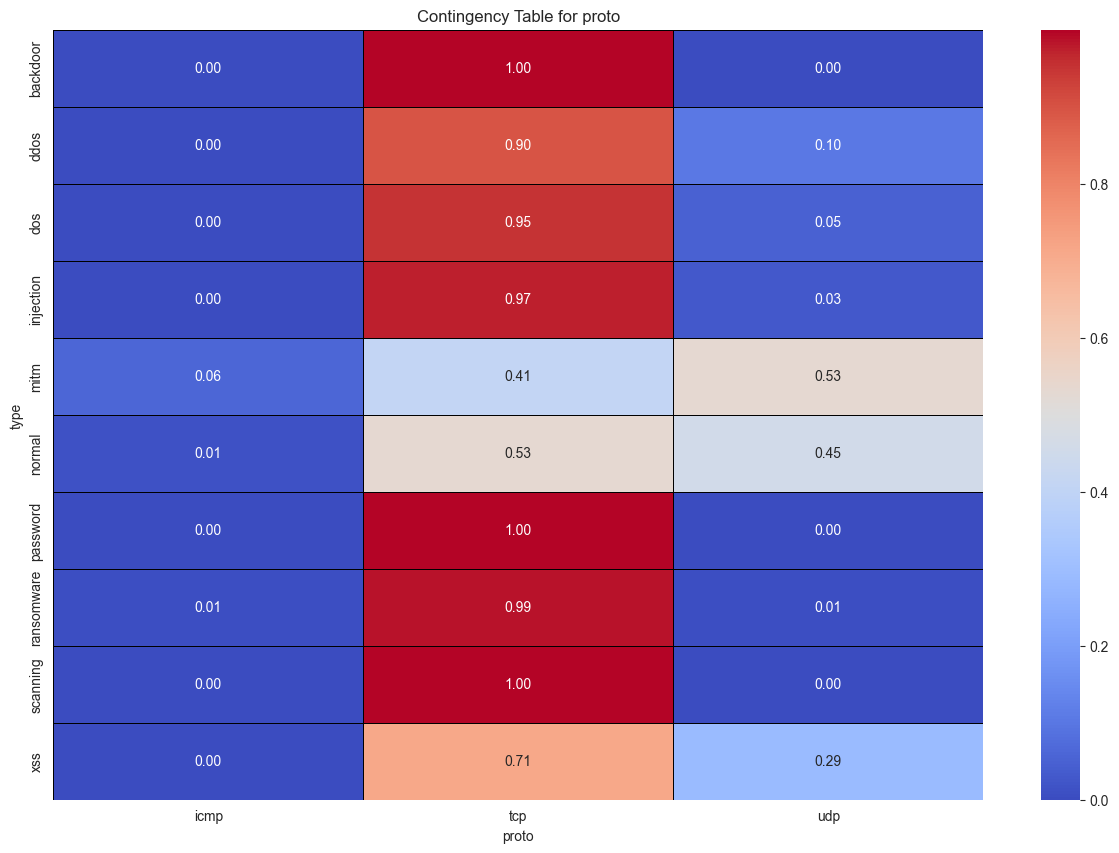

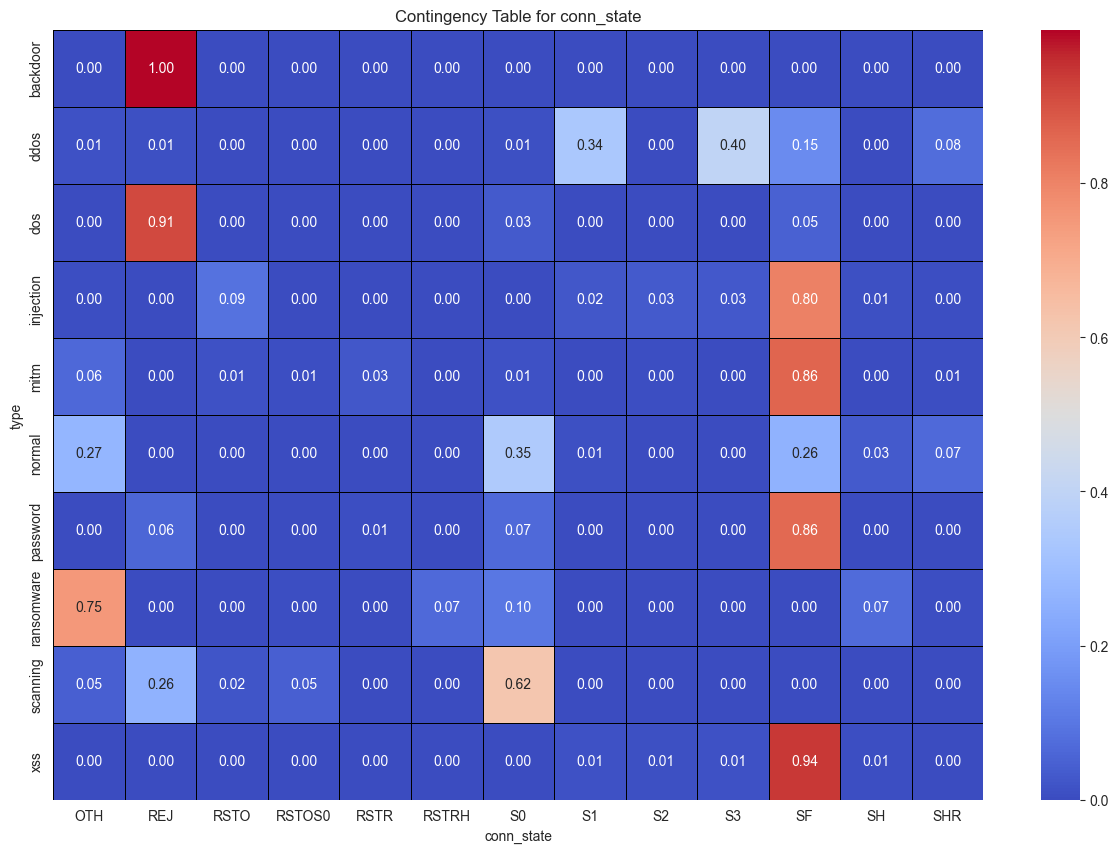

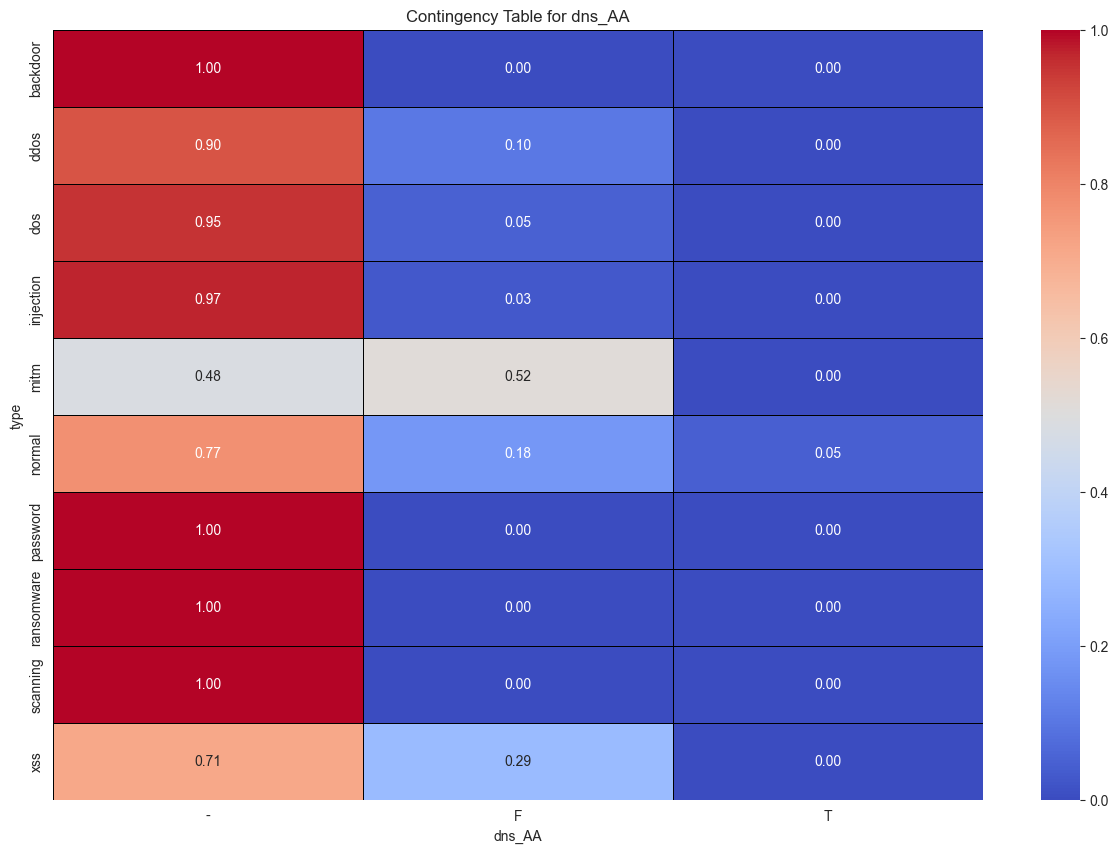

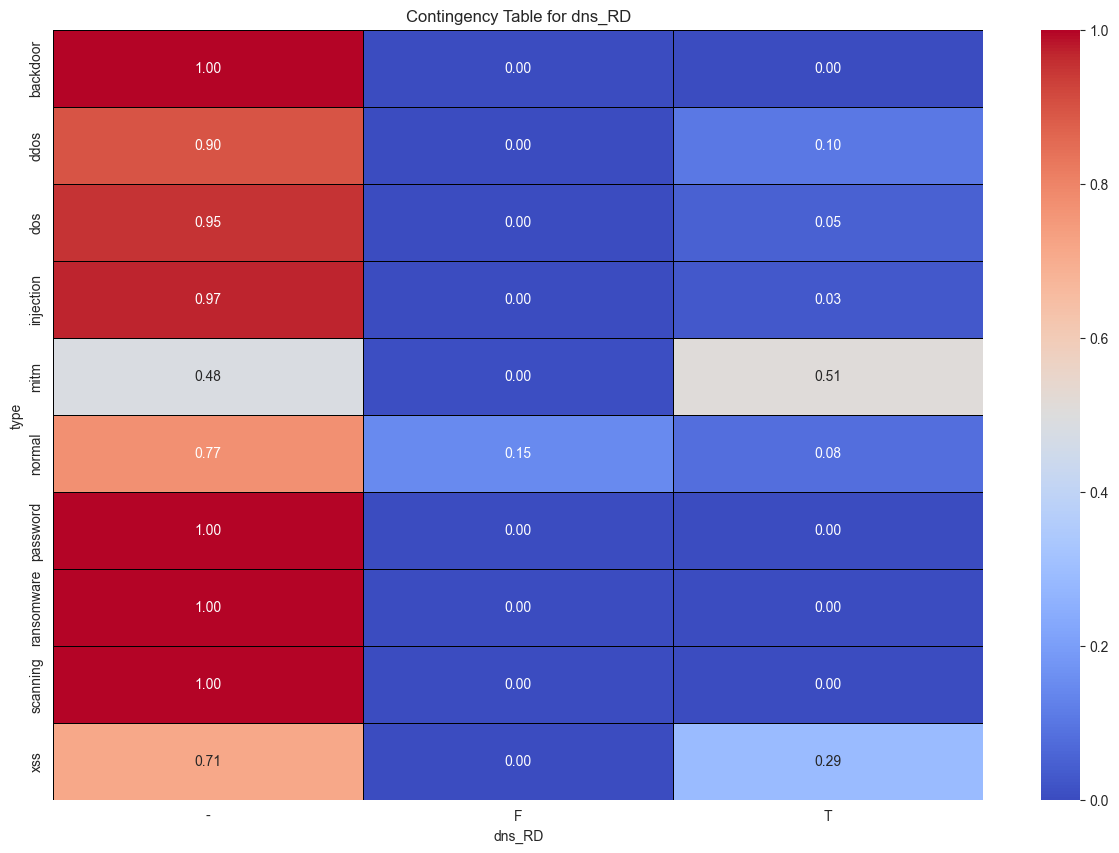

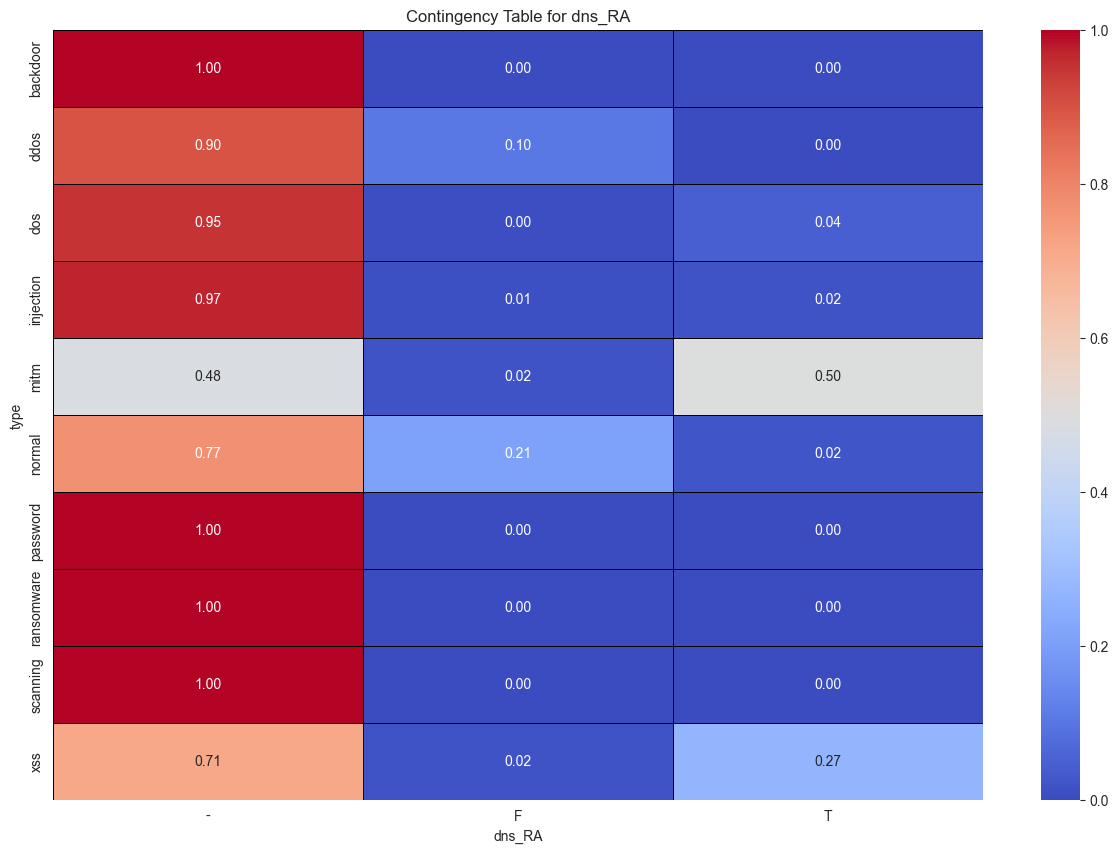

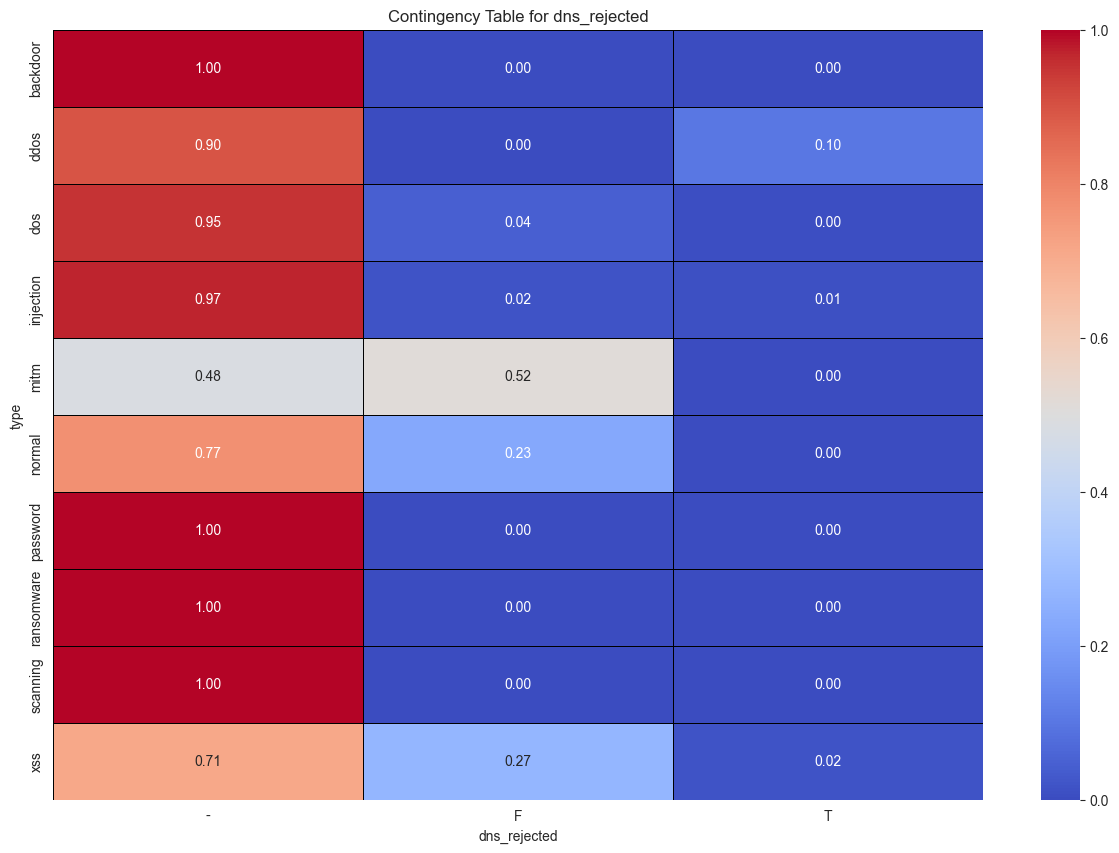

['plots/contingency_table_proto.png', 'plots/contingency_table_conn_state.png', 'plots/contingency_table_dns_AA.png', 'plots/contingency_table_dns_RD.png', 'plots/contingency_table_dns_RA.png', 'plots/contingency_table_dns_rejected.png']


In [49]:
# get categorical columns
chosen_categorical_columns = ["proto", "conn_state", "dns_AA", "dns_RD", "dns_RA", "dns_rejected"]

filenames = []
# contingency table
for column in chosen_categorical_columns:
    if df1[column].nunique() <= 15:
        contingency_table = pd.crosstab(df1["type"], df1[column], )
        percent_table = contingency_table.div(contingency_table.sum(axis=1), axis=0)
        plt.figure(figsize=(15, 10))
        sns.heatmap(percent_table, annot=True, fmt=".2f", cmap='coolwarm', linecolor='black', linewidths=0.5)
        plt.title(f"Contingency Table for {column}")
        plt.savefig(f"plots/contingency_table_{column}.png")
        filenames.append(f"plots/contingency_table_{column}.png")
        plt.show()

print(filenames)